### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.4 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/"

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
class TwoClassImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

        self.class_to_idx = {
            'anormal': 0,
            'bsuspectglaucoma': 1,
            'cglaucoma': 1
        }

    def __getitem__(self, index):
        # Get original image and label
        path, original_target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample = self.transform(sample)

        target_class_name = self.classes[original_target]
        target = self.class_to_idx[target_class_name]

        return sample, target

In [ ]:
def load_data(batch_size, dataset, PAPILA_dual_class=False):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

    if PAPILA_dual_class:
      train_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
      val_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'val'), transform=valid_test_transform)
      test_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'test'), transform=valid_test_transform)

    else:
      train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
      val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
      test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader


  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  return train_loader, valid_loader, test_loader

### Hybrid Quantum-classical Neural Network Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_auc = float('-inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_auroc > best_val_auc:
            best_val_auc = val_auroc
            best_model_weights = model.state_dict()

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
  plt.style.use("seaborn")
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

  ax1.plot(quantum_loss, label="With quantum layer")
  ax1.plot(normal_loss, label="Without quantum layer")
  ax1.set_ylabel("Loss")
  ax1.set_ylim([0, 1])
  ax1.set_xlabel("Epoch")
  ax1.legend()

  ax2.plot(quantum_acc, label="With quantum layer")
  ax2.plot(normal_acc, label="Without quantum layer")
  ax2.set_ylabel("Accuracy")
  ax2.set_ylim([0, 100])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  ax2.plot(quantum_auc, label="With quantum layer")
  ax2.plot(normal_auc, label="Without quantum layer")
  ax2.set_ylabel("ROCAUC")
  ax2.set_ylim([0, 1])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Hybrid model predictions
            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)  # Probability for each class

            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)  # Probability for each class

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)

    # Calculate accuracy
    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)

    # Calculate F1 Score
    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')

    print(f'Hybrid Model Accuracy: {accuracy_hybrid * 100:.2f}%')
    print(f'Normal Model Accuracy: {accuracy_normal * 100:.2f}%')
    print(f'Hybrid Model F1 Score: {f1_hybrid:.4f}')
    print(f'Normal Model F1 Score: {f1_normal:.4f}')

    if num_classes == 2:  # Binary Classification
        # Extract the probabilities of the positive class (class 1)
        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        # Calculate AUC
        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUC: {auc_hybrid:.4f}')
        print(f'Normal Model AUC: {auc_normal:.4f}')

        # Plot ROC curves
        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUC = {auc_hybrid:.4f}')
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
        plt.title('ROC Curve - Hybrid and Normal Models')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Calculate and print AUPR
        precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels, all_probs_hybrid_class1)
        precision_normal, recall_normal, _ = precision_recall_curve(all_labels, all_probs_normal_class1)

        aupr_hybrid = auc(recall_hybrid, precision_hybrid)
        aupr_normal = auc(recall_normal, precision_normal)

        print(f'Hybrid Model AUPR: {aupr_hybrid:.4f}')
        print(f'Normal Model AUPR: {aupr_normal:.4f}')

        # Plot Precision-Recall curves
        plt.figure(figsize=(10, 6))
        plt.plot(recall_hybrid, precision_hybrid, label=f'Hybrid Model AUPR = {aupr_hybrid:.4f}')
        plt.plot(recall_normal, precision_normal, label=f'Normal Model AUPR = {aupr_normal:.4f}')
        plt.title('Precision-Recall Curve - Hybrid and Normal Models')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.show()

    else:  # Multi-class Classification
        # For multi-class, handle per class ROC and PR curves
        for i in range(num_classes):
            # Calculate AUC for each class
            fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels == i, all_probs_hybrid[:, i])
            fpr_normal, tpr_normal, _ = roc_curve(all_labels == i, all_probs_normal[:, i])

            auc_hybrid = roc_auc_score(all_labels == i, all_probs_hybrid[:, i])
            auc_normal = roc_auc_score(all_labels == i, all_probs_normal[:, i])

            plt.figure(figsize=(10, 6))
            plt.plot(fpr_hybrid, tpr_hybrid, label=f'Class {i} Hybrid Model AUC = {auc_hybrid:.4f}')
            plt.plot(fpr_normal, tpr_normal, label=f'Class {i} Normal Model AUC = {auc_normal:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - Class {i}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

            # Precision-Recall Curve
            precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels == i, all_probs_hybrid[:, i])
            precision_normal, recall_normal, _ = precision_recall_curve(all_labels == i, all_probs_normal[:, i])

            aupr_hybrid = auc(recall_hybrid, precision_hybrid)
            aupr_normal = auc(recall_normal, precision_normal)

            plt.figure(figsize=(10, 6))
            plt.plot(recall_hybrid, precision_hybrid, label=f'Class {i} Hybrid Model AUPR = {aupr_hybrid:.4f}')
            plt.plot(recall_normal, precision_normal, label=f'Class {i} Normal Model AUPR = {aupr_normal:.4f}')
            plt.title(f'Precision-Recall Curve - Class {i}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc='lower left')
            plt.show()


# Experiments: Training Normal + Hybrid Models on IDRID, Then Testing on IDRID

In [ ]:
n_epochs = 100
num_classes = 5
batch_size = 32
q_depth = 4
dataset = "IDRID"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

## Seed Experiment 1

In [ ]:
seed = 0
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4661, Training Accuracy: 28.12%, Training AUROC: 0.4301
Validation Loss: 1.3064, Validation Accuracy: 29.69%, Validation AUROC: 0.4643
Epoch [2/100]
Training Loss: 1.4603, Training Accuracy: 23.83%, Training AUROC: 0.4087
Validation Loss: 1.2065, Validation Accuracy: 29.69%, Validation AUROC: 0.5063
Epoch [3/100]
Training Loss: 1.3687, Training Accuracy: 34.38%, Training AUROC: 0.4830
Validation Loss: 1.1502, Validation Accuracy: 37.50%, Validation AUROC: 0.5494
Epoch [4/100]
Training Loss: 1.3458, Training Accuracy: 30.08%, Training AUROC: 0.5106
Validation Loss: 1.1186, Validation Accuracy: 46.88%, Validation AUROC: 0.5862
Epoch [5/100]
Training Loss: 1.3192, Training Accuracy: 38.67%, Training AUROC: 0.5622
Validation Loss: 1.0851, Validation Accuracy: 46.88%, Validation AUROC: 0.6333
Epoch [6/100]
Training Loss: 1.2699, Training Accuracy: 40.23%, Training AUROC: 0.6151
Validation Loss: 1.0598, Validation Accuracy: 53.12%, Validation AUROC: 0.6682
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4543, Training Accuracy: 25.39%, Training AUROC: 0.5732
Validation Loss: 1.2478, Validation Accuracy: 31.25%, Validation AUROC: 0.6370
Epoch [2/100]
Training Loss: 1.4047, Training Accuracy: 26.95%, Training AUROC: 0.5423
Validation Loss: 1.1959, Validation Accuracy: 42.19%, Validation AUROC: 0.6486
Epoch [3/100]
Training Loss: 1.3625, Training Accuracy: 32.42%, Training AUROC: 0.5882
Validation Loss: 1.1644, Validation Accuracy: 42.19%, Validation AUROC: 0.6977
Epoch [4/100]
Training Loss: 1.3343, Training Accuracy: 40.23%, Training AUROC: 0.6377
Validation Loss: 1.1463, Validation Accuracy: 46.88%, Validation AUROC: 0.7056
Epoch [5/100]
Training Loss: 1.3184, Training Accuracy: 38.67%, Training AUROC: 0.6834
Validation Loss: 1.1321, Validation Accuracy: 53.12%, Validation AUROC: 0.7151
Epoch [6/100]
Training Loss: 1.2998, Training Accuracy: 46.48%, Training AUROC: 0.7140
Validation Loss: 1.1180, Validation Accuracy: 54.69%, Validation AUROC: 0.7107
Epoc

<ipython-input-4-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


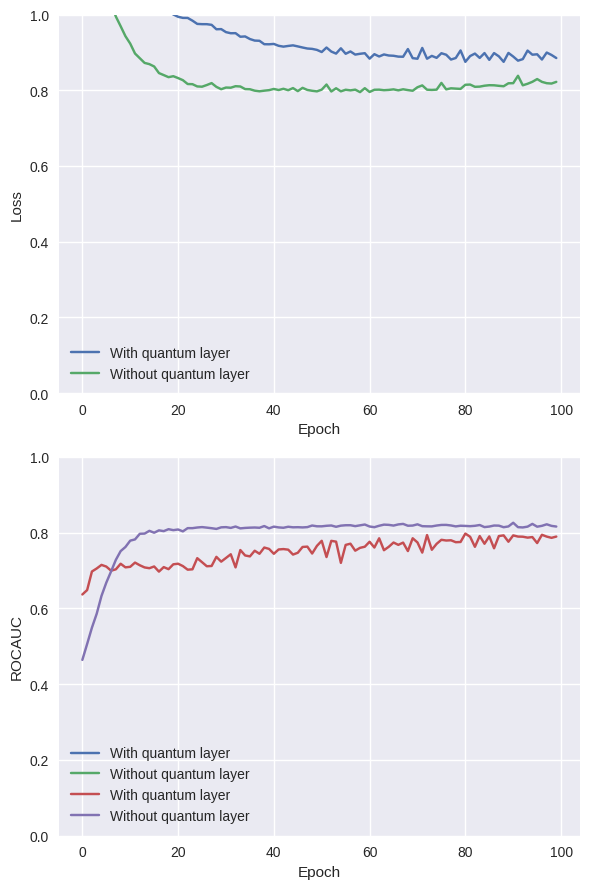

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 64.06%
Normal Model Accuracy: 60.94%
Hybrid Model F1 Score: 0.5897
Normal Model F1 Score: 0.5776
Hybrid Model AUC: 0.8105
Normal Model AUC: 0.8335
Hybrid Model AUPR: 0.4699
Normal Model AUPR: 0.5002


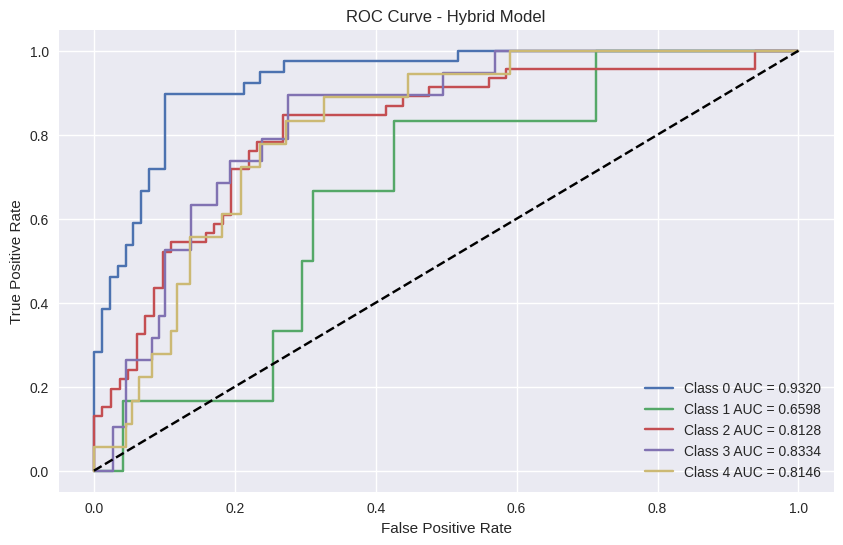

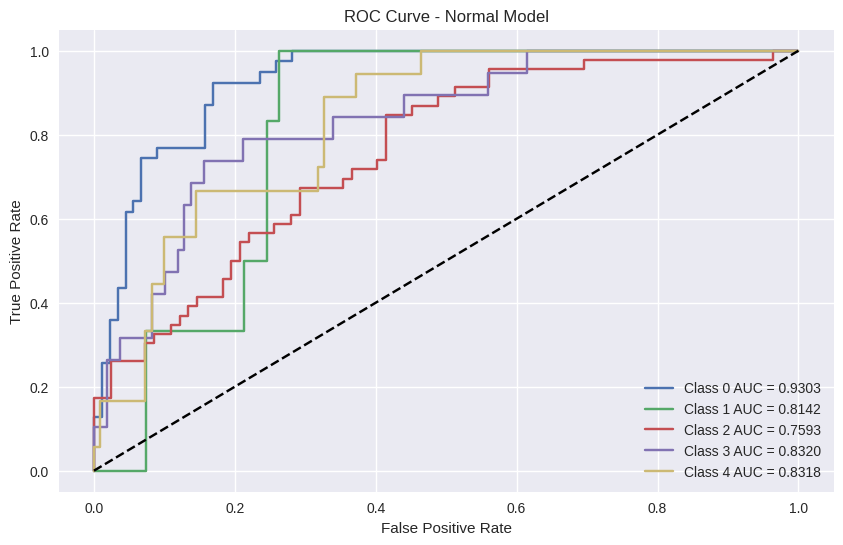

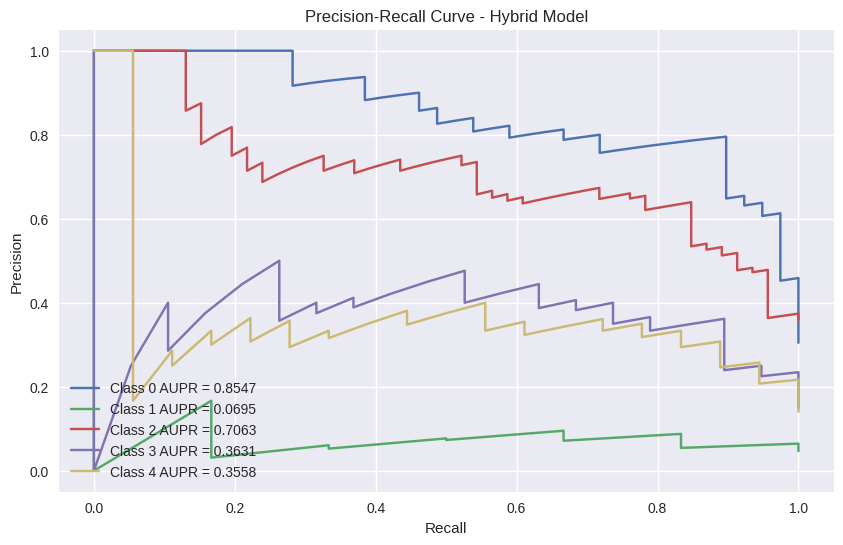

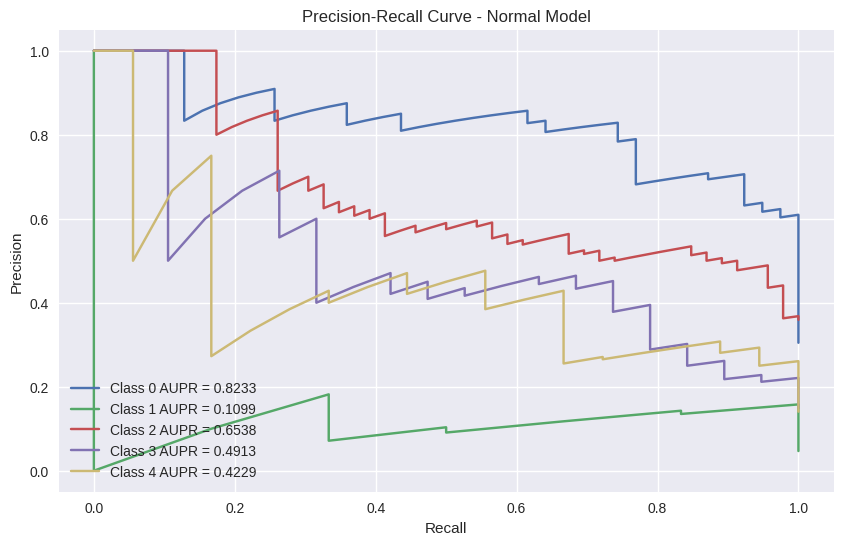

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = 42
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.6350, Training Accuracy: 11.72%, Training AUROC: 0.4791
Validation Loss: 1.4043, Validation Accuracy: 15.62%, Validation AUROC: 0.4970
Epoch [2/100]
Training Loss: 1.4887, Training Accuracy: 21.09%, Training AUROC: 0.5006
Validation Loss: 1.3171, Validation Accuracy: 18.75%, Validation AUROC: 0.4831
Epoch [3/100]
Training Loss: 1.3782, Training Accuracy: 27.34%, Training AUROC: 0.5204
Validation Loss: 1.2301, Validation Accuracy: 23.44%, Validation AUROC: 0.4766
Epoch [4/100]
Training Loss: 1.3225, Training Accuracy: 33.98%, Training AUROC: 0.5586
Validation Loss: 1.1956, Validation Accuracy: 26.56%, Validation AUROC: 0.4862
Epoch [5/100]
Training Loss: 1.2866, Training Accuracy: 35.16%, Training AUROC: 0.5829
Validation Loss: 1.1589, Validation Accuracy: 28.12%, Validation AUROC: 0.5381
Epoch [6/100]
Training Loss: 1.2598, Training Accuracy: 37.11%, Training AUROC: 0.6051
Validation Loss: 1.1252, Validation Accuracy: 34.38%, Validation AUROC: 0.5893
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5329, Training Accuracy: 29.69%, Training AUROC: 0.4556
Validation Loss: 1.3689, Validation Accuracy: 31.25%, Validation AUROC: 0.5381
Epoch [2/100]
Training Loss: 1.4706, Training Accuracy: 32.81%, Training AUROC: 0.4740
Validation Loss: 1.2993, Validation Accuracy: 32.81%, Validation AUROC: 0.4957
Epoch [3/100]
Training Loss: 1.4209, Training Accuracy: 33.59%, Training AUROC: 0.4984
Validation Loss: 1.1951, Validation Accuracy: 42.19%, Validation AUROC: 0.5276
Epoch [4/100]
Training Loss: 1.3498, Training Accuracy: 37.89%, Training AUROC: 0.5371
Validation Loss: 1.1629, Validation Accuracy: 42.19%, Validation AUROC: 0.5702
Epoch [5/100]
Training Loss: 1.3414, Training Accuracy: 37.11%, Training AUROC: 0.5684
Validation Loss: 1.1534, Validation Accuracy: 43.75%, Validation AUROC: 0.6082
Epoch [6/100]
Training Loss: 1.3248, Training Accuracy: 37.89%, Training AUROC: 0.5867
Validation Loss: 1.1431, Validation Accuracy: 50.00%, Validation AUROC: 0.6449
Epoc

<ipython-input-4-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


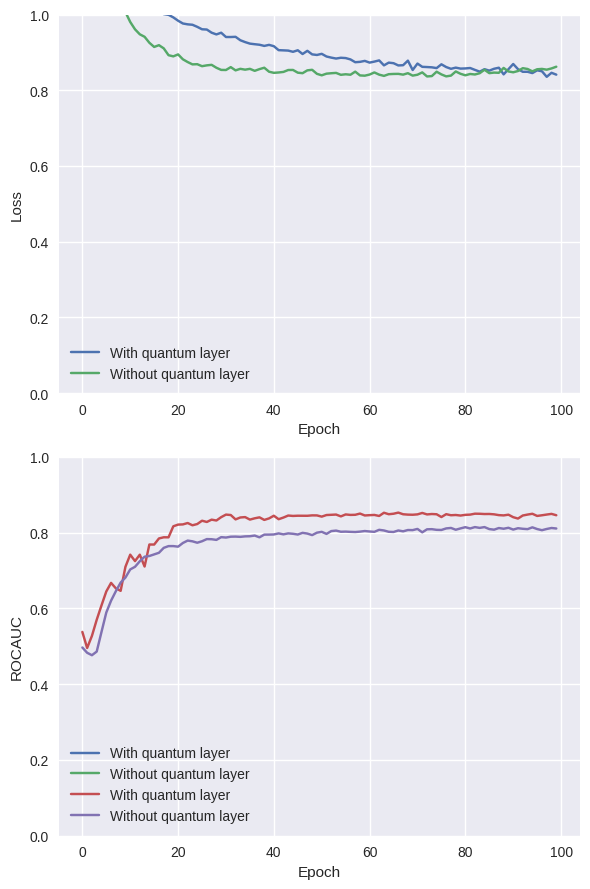

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 63.28%
Normal Model Accuracy: 58.59%
Hybrid Model F1 Score: 0.5688
Normal Model F1 Score: 0.5566
Hybrid Model AUC: 0.8322
Normal Model AUC: 0.8344
Hybrid Model AUPR: 0.5062
Normal Model AUPR: 0.5114


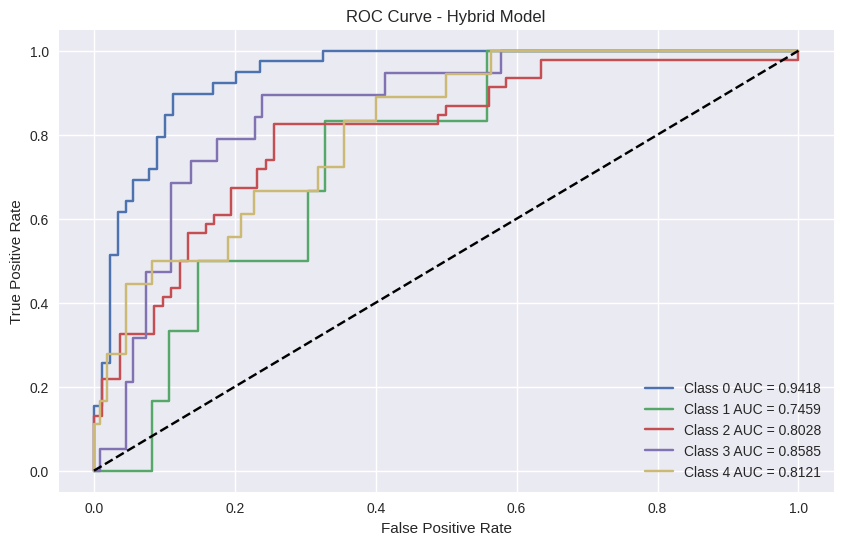

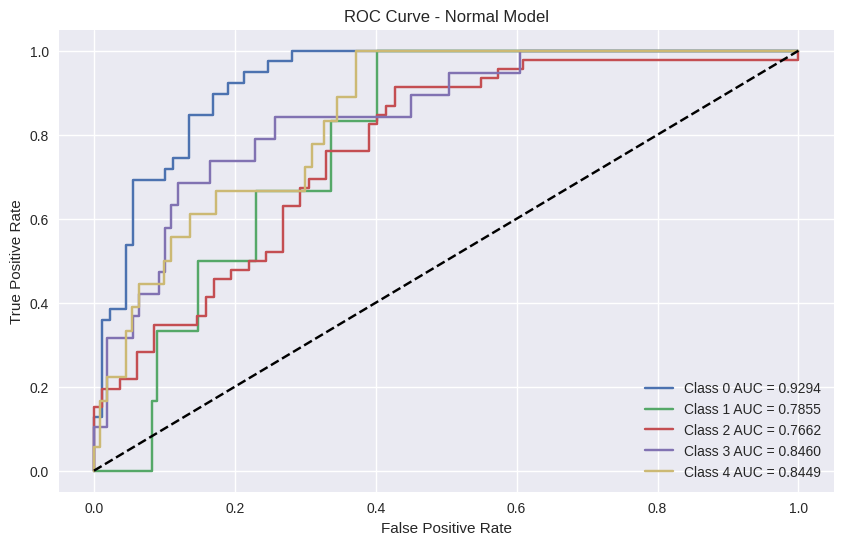

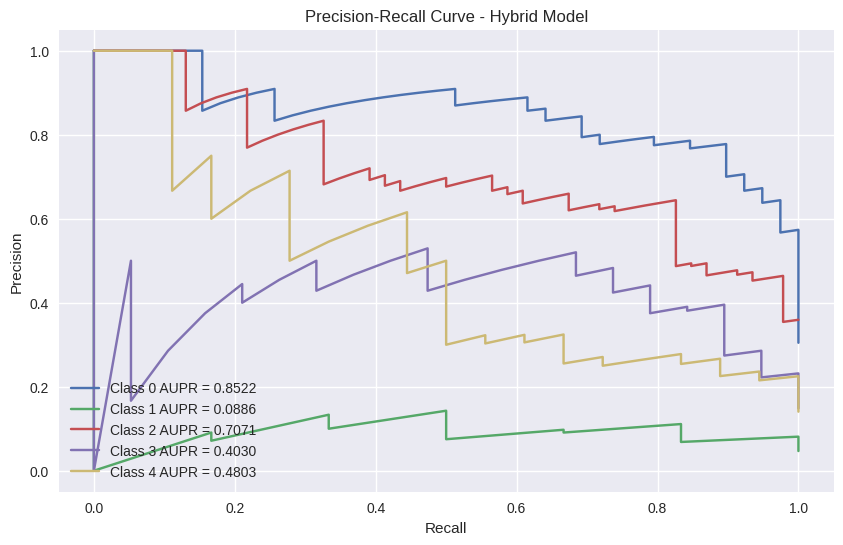

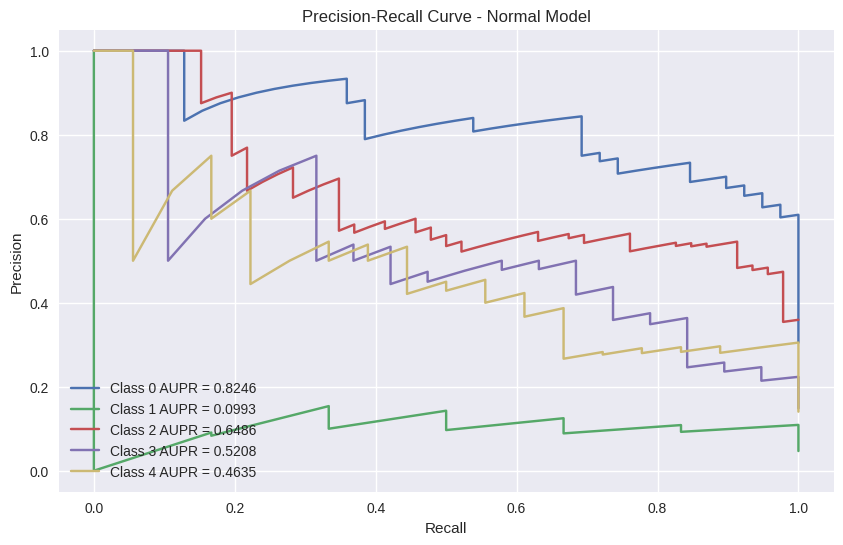

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = 5923
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.6635, Training Accuracy: 13.28%, Training AUROC: 0.4845
Validation Loss: 1.3988, Validation Accuracy: 25.00%, Validation AUROC: 0.5380
Epoch [2/100]
Training Loss: 1.5242, Training Accuracy: 21.88%, Training AUROC: 0.4963
Validation Loss: 1.2820, Validation Accuracy: 28.12%, Validation AUROC: 0.4917
Epoch [3/100]
Training Loss: 1.4083, Training Accuracy: 27.34%, Training AUROC: 0.5073
Validation Loss: 1.1894, Validation Accuracy: 26.56%, Validation AUROC: 0.5050
Epoch [4/100]
Training Loss: 1.3553, Training Accuracy: 26.17%, Training AUROC: 0.5197
Validation Loss: 1.1402, Validation Accuracy: 29.69%, Validation AUROC: 0.5406
Epoch [5/100]
Training Loss: 1.3137, Training Accuracy: 30.08%, Training AUROC: 0.5989
Validation Loss: 1.1116, Validation Accuracy: 34.38%, Validation AUROC: 0.5943
Epoch [6/100]
Training Loss: 1.2787, Training Accuracy: 35.94%, Training AUROC: 0.6238
Validation Loss: 1.0758, Validation Accuracy: 43.75%, Validation AUROC: 0.6416
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5727, Training Accuracy: 17.19%, Training AUROC: 0.4373
Validation Loss: 1.4649, Validation Accuracy: 6.25%, Validation AUROC: 0.3417
Epoch [2/100]
Training Loss: 1.5259, Training Accuracy: 19.53%, Training AUROC: 0.4533
Validation Loss: 1.3675, Validation Accuracy: 14.06%, Validation AUROC: 0.3857
Epoch [3/100]
Training Loss: 1.4595, Training Accuracy: 28.52%, Training AUROC: 0.4673
Validation Loss: 1.2999, Validation Accuracy: 26.56%, Validation AUROC: 0.4295
Epoch [4/100]
Training Loss: 1.4074, Training Accuracy: 31.64%, Training AUROC: 0.5325
Validation Loss: 1.2386, Validation Accuracy: 31.25%, Validation AUROC: 0.4942
Epoch [5/100]
Training Loss: 1.3627, Training Accuracy: 33.98%, Training AUROC: 0.5878
Validation Loss: 1.2004, Validation Accuracy: 40.62%, Validation AUROC: 0.5680
Epoch [6/100]
Training Loss: 1.3513, Training Accuracy: 37.50%, Training AUROC: 0.6198
Validation Loss: 1.1774, Validation Accuracy: 42.19%, Validation AUROC: 0.6237
Epoch

<ipython-input-4-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


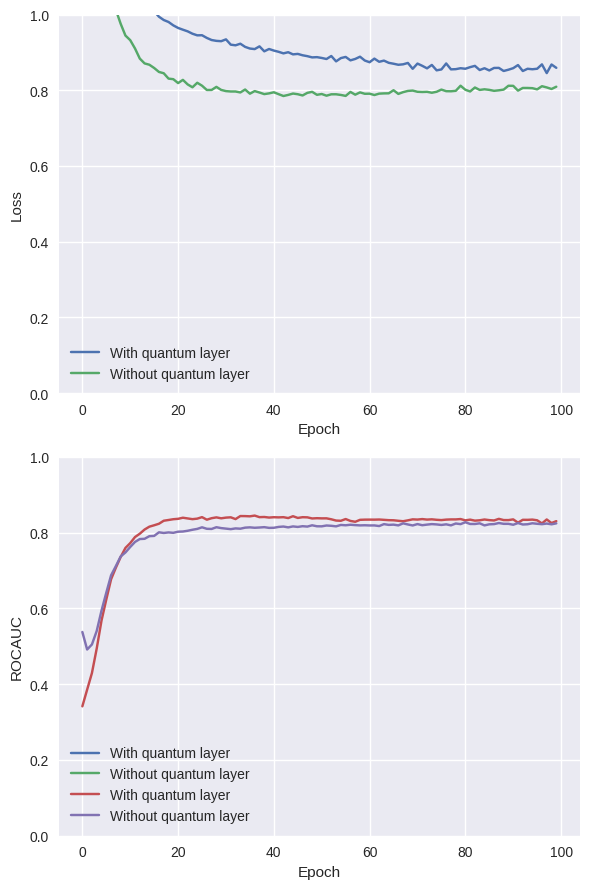

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 60.94%
Normal Model Accuracy: 60.16%
Hybrid Model F1 Score: 0.5744
Normal Model F1 Score: 0.5715
Hybrid Model AUC: 0.8548
Normal Model AUC: 0.8289
Hybrid Model AUPR: 0.5667
Normal Model AUPR: 0.5144


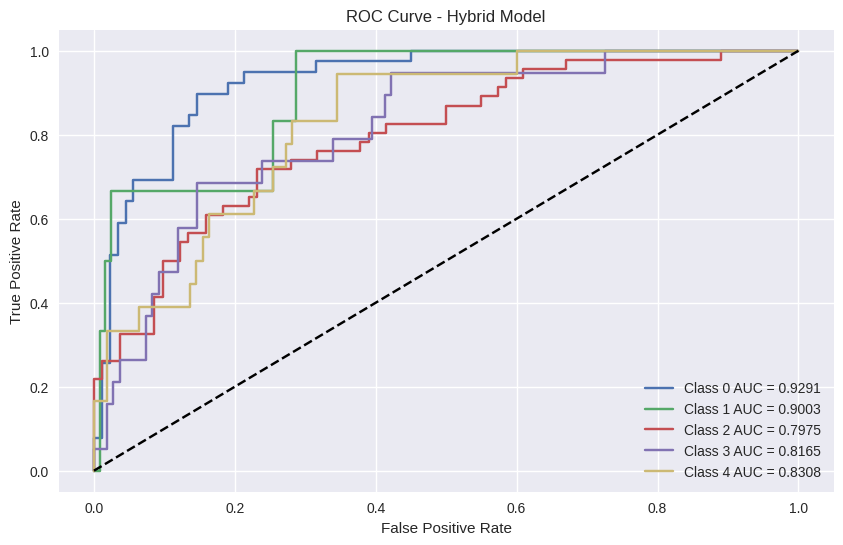

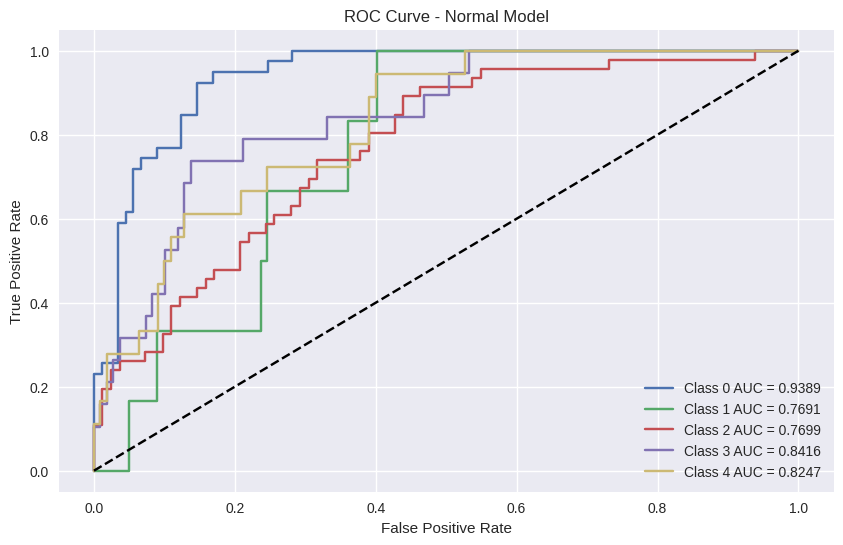

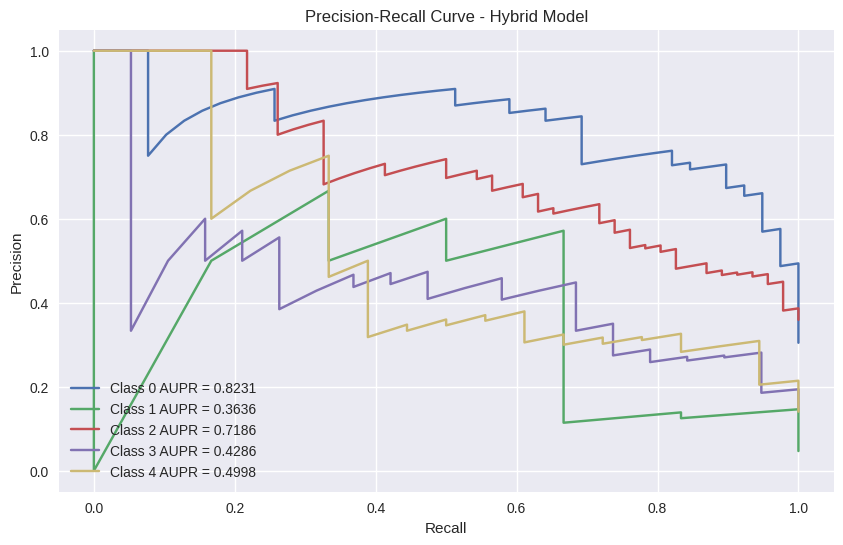

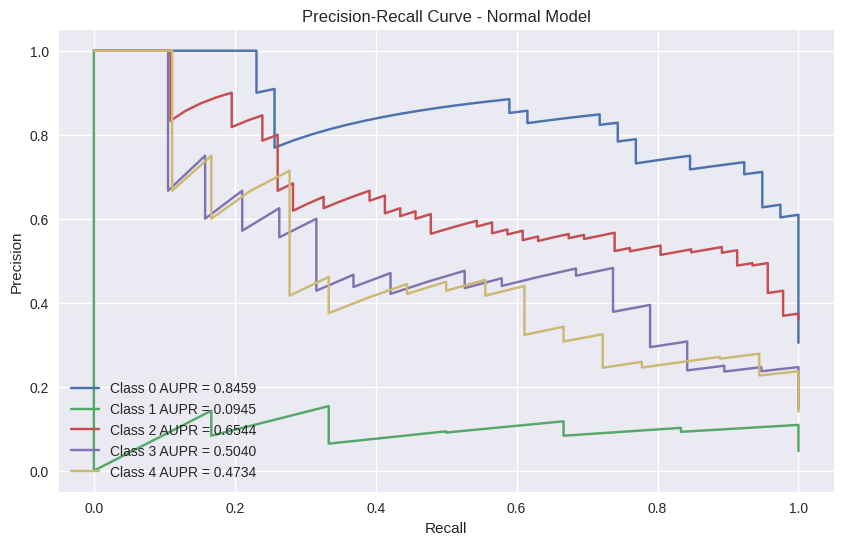

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [ ]:
seed = 8932
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4733, Training Accuracy: 25.00%, Training AUROC: 0.4871
Validation Loss: 1.3572, Validation Accuracy: 26.56%, Validation AUROC: 0.4211
Epoch [2/100]
Training Loss: 1.3879, Training Accuracy: 33.59%, Training AUROC: 0.5023
Validation Loss: 1.2337, Validation Accuracy: 40.62%, Validation AUROC: 0.4558
Epoch [3/100]
Training Loss: 1.3541, Training Accuracy: 32.42%, Training AUROC: 0.5230
Validation Loss: 1.1589, Validation Accuracy: 43.75%, Validation AUROC: 0.4994
Epoch [4/100]
Training Loss: 1.3123, Training Accuracy: 41.41%, Training AUROC: 0.5495
Validation Loss: 1.1229, Validation Accuracy: 46.88%, Validation AUROC: 0.5179
Epoch [5/100]
Training Loss: 1.3011, Training Accuracy: 41.02%, Training AUROC: 0.6004
Validation Loss: 1.0964, Validation Accuracy: 50.00%, Validation AUROC: 0.5495
Epoch [6/100]
Training Loss: 1.2620, Training Accuracy: 39.45%, Training AUROC: 0.6366
Validation Loss: 1.0743, Validation Accuracy: 50.00%, Validation AUROC: 0.5798
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4524, Training Accuracy: 18.36%, Training AUROC: 0.5131
Validation Loss: 1.3156, Validation Accuracy: 17.19%, Validation AUROC: 0.4203
Epoch [2/100]
Training Loss: 1.4367, Training Accuracy: 19.92%, Training AUROC: 0.5088
Validation Loss: 1.2518, Validation Accuracy: 29.69%, Validation AUROC: 0.4674
Epoch [3/100]
Training Loss: 1.4004, Training Accuracy: 24.22%, Training AUROC: 0.5364
Validation Loss: 1.2169, Validation Accuracy: 35.94%, Validation AUROC: 0.4904
Epoch [4/100]
Training Loss: 1.3800, Training Accuracy: 28.91%, Training AUROC: 0.5242
Validation Loss: 1.1774, Validation Accuracy: 32.81%, Validation AUROC: 0.5163
Epoch [5/100]
Training Loss: 1.3542, Training Accuracy: 30.86%, Training AUROC: 0.5407
Validation Loss: 1.1712, Validation Accuracy: 32.81%, Validation AUROC: 0.5364
Epoch [6/100]
Training Loss: 1.3437, Training Accuracy: 31.25%, Training AUROC: 0.6079
Validation Loss: 1.1593, Validation Accuracy: 34.38%, Validation AUROC: 0.5528
Epoc

<ipython-input-4-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


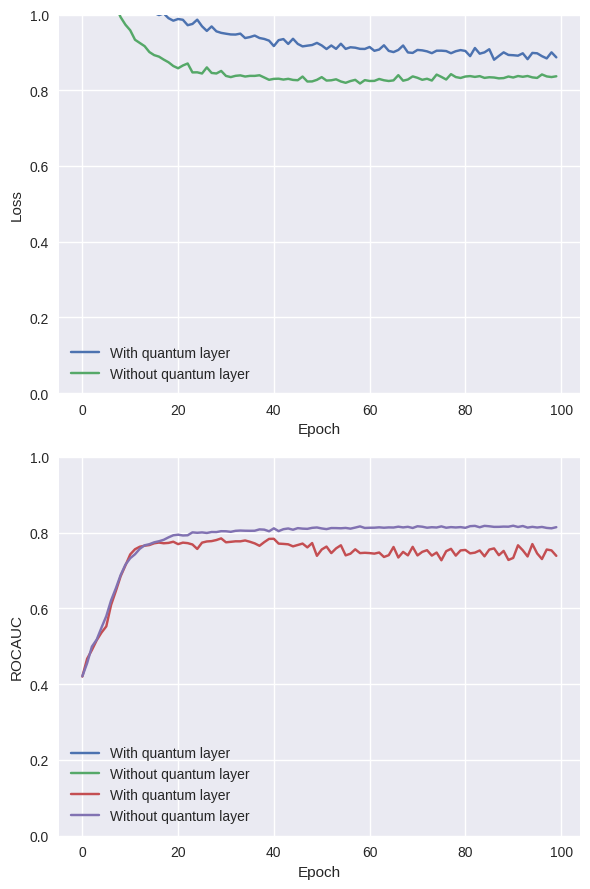

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 57.81%
Normal Model Accuracy: 60.94%
Hybrid Model F1 Score: 0.5512
Normal Model F1 Score: 0.5770
Hybrid Model AUC: 0.8016
Normal Model AUC: 0.8497
Hybrid Model AUPR: 0.4852
Normal Model AUPR: 0.5212


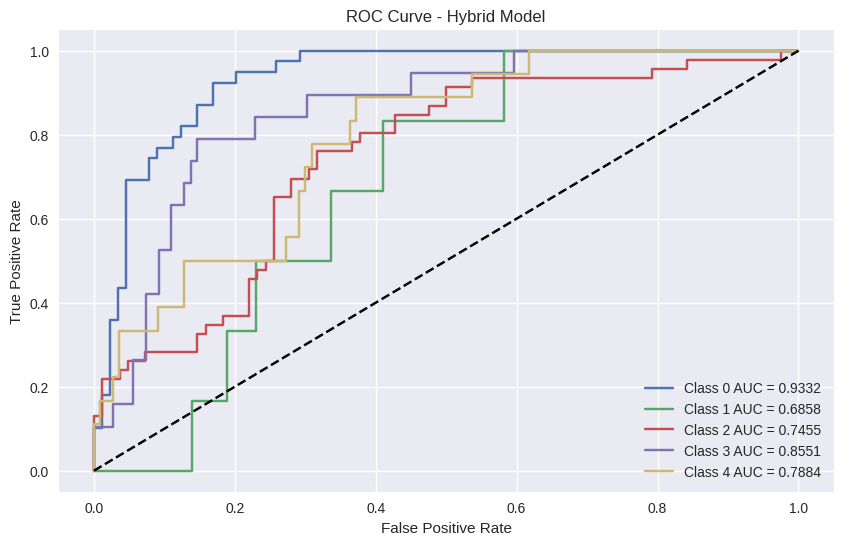

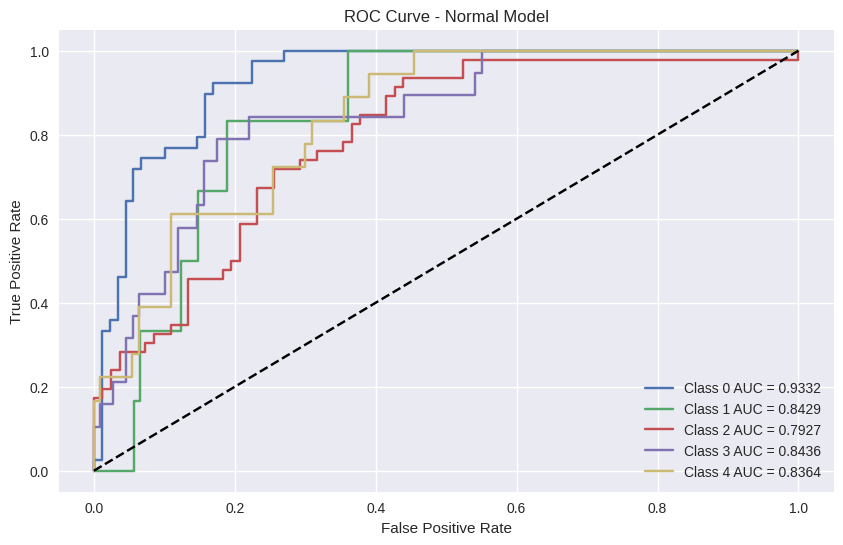

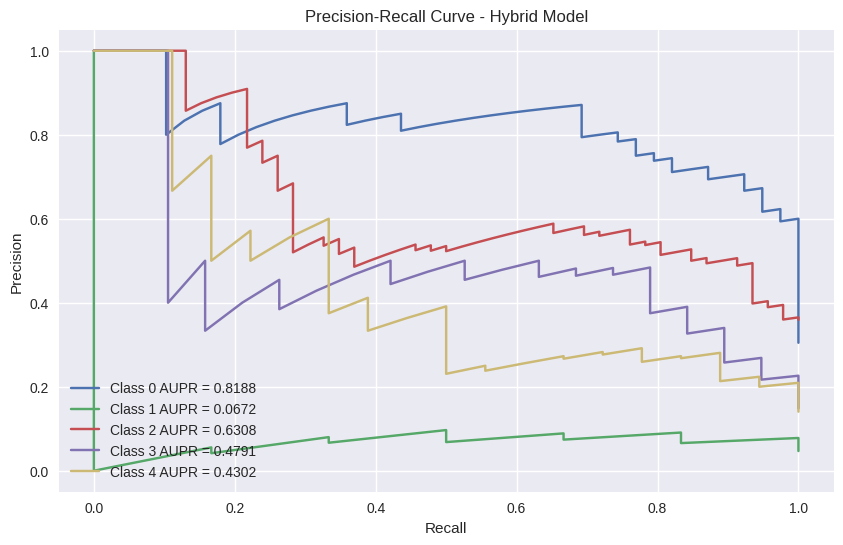

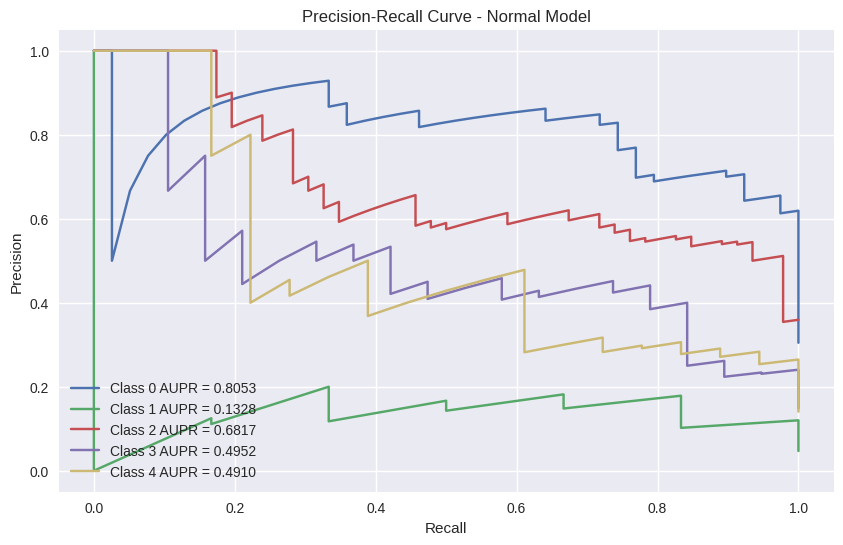

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 5

In [ ]:
seed = 56
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4785, Training Accuracy: 30.08%, Training AUROC: 0.5535
Validation Loss: 1.3976, Validation Accuracy: 28.12%, Validation AUROC: 0.3841
Epoch [2/100]
Training Loss: 1.4310, Training Accuracy: 27.73%, Training AUROC: 0.5328
Validation Loss: 1.2261, Validation Accuracy: 32.81%, Validation AUROC: 0.5132
Epoch [3/100]
Training Loss: 1.3248, Training Accuracy: 31.64%, Training AUROC: 0.5771
Validation Loss: 1.1315, Validation Accuracy: 35.94%, Validation AUROC: 0.5705
Epoch [4/100]
Training Loss: 1.2760, Training Accuracy: 39.06%, Training AUROC: 0.6110
Validation Loss: 1.0941, Validation Accuracy: 39.06%, Validation AUROC: 0.6210
Epoch [5/100]
Training Loss: 1.2368, Training Accuracy: 41.80%, Training AUROC: 0.6348
Validation Loss: 1.0630, Validation Accuracy: 40.62%, Validation AUROC: 0.6532
Epoch [6/100]
Training Loss: 1.2198, Training Accuracy: 39.45%, Training AUROC: 0.6920
Validation Loss: 1.0383, Validation Accuracy: 51.56%, Validation AUROC: 0.6758
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4138, Training Accuracy: 31.25%, Training AUROC: 0.5231
Validation Loss: 1.2367, Validation Accuracy: 35.94%, Validation AUROC: 0.5850
Epoch [2/100]
Training Loss: 1.4079, Training Accuracy: 32.03%, Training AUROC: 0.5021
Validation Loss: 1.2322, Validation Accuracy: 37.50%, Validation AUROC: 0.5859
Epoch [3/100]
Training Loss: 1.3938, Training Accuracy: 33.59%, Training AUROC: 0.5242
Validation Loss: 1.2274, Validation Accuracy: 40.62%, Validation AUROC: 0.6234
Epoch [4/100]
Training Loss: 1.3797, Training Accuracy: 37.11%, Training AUROC: 0.5514
Validation Loss: 1.2201, Validation Accuracy: 42.19%, Validation AUROC: 0.6546
Epoch [5/100]
Training Loss: 1.3590, Training Accuracy: 42.19%, Training AUROC: 0.5939
Validation Loss: 1.2049, Validation Accuracy: 40.62%, Validation AUROC: 0.6817
Epoch [6/100]
Training Loss: 1.3738, Training Accuracy: 34.77%, Training AUROC: 0.6118
Validation Loss: 1.1920, Validation Accuracy: 40.62%, Validation AUROC: 0.7077
Epoc

<ipython-input-4-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


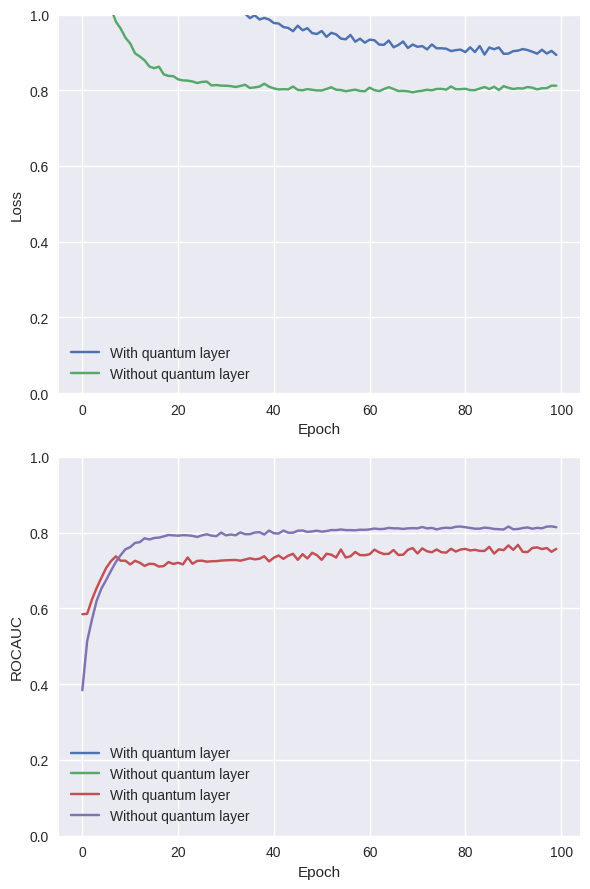

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 58.59%
Normal Model Accuracy: 59.38%
Hybrid Model F1 Score: 0.5533
Normal Model F1 Score: 0.5639
Hybrid Model AUC: 0.7774
Normal Model AUC: 0.8471
Hybrid Model AUPR: 0.5102
Normal Model AUPR: 0.5368


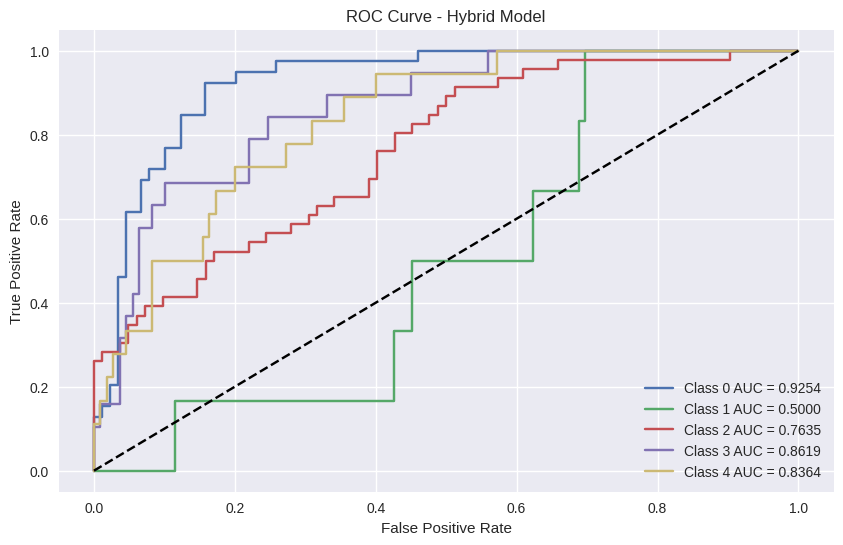

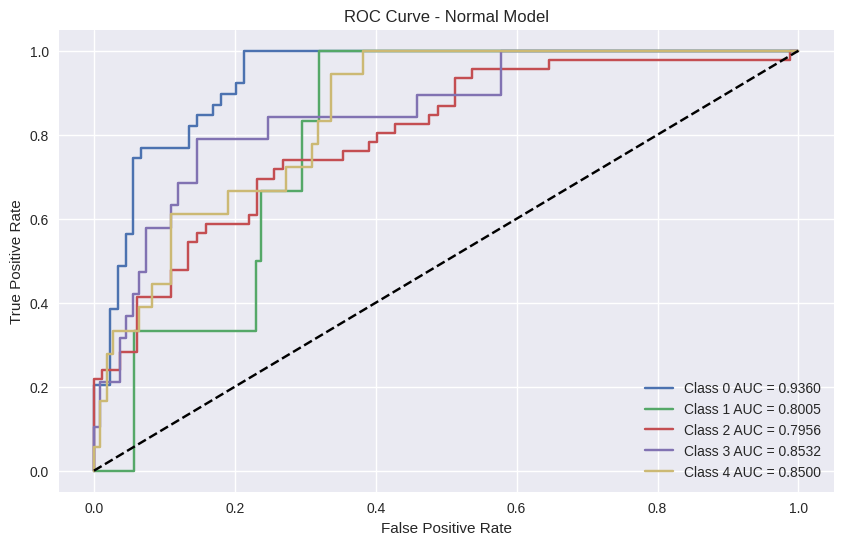

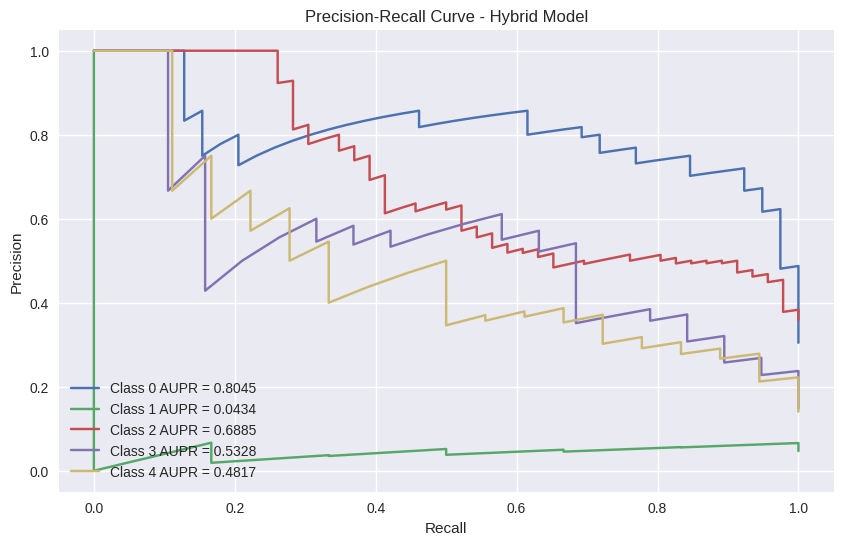

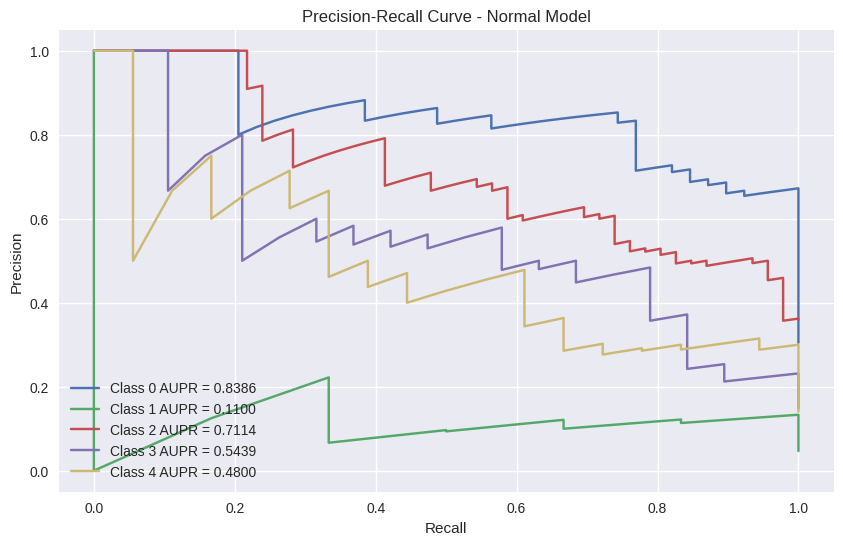

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Experimenting IDRID Normal and Quantum Models on APTOS and Messidor

## Experimenting IDRID on APTOS

In [ ]:
batch_size = 32
dataset = "APTOS"
num_classes=5
q_depth = 4

In [ ]:
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)

### Testing Model From Seed 1

Hybrid Model Accuracy: 77.11%
Normal Model Accuracy: 77.57%
Hybrid Model F1 Score: 0.7475
Normal Model F1 Score: 0.7648
Hybrid Model AUC: 0.8998
Normal Model AUC: 0.9096
Hybrid Model AUPR: 0.5557
Normal Model AUPR: 0.5935


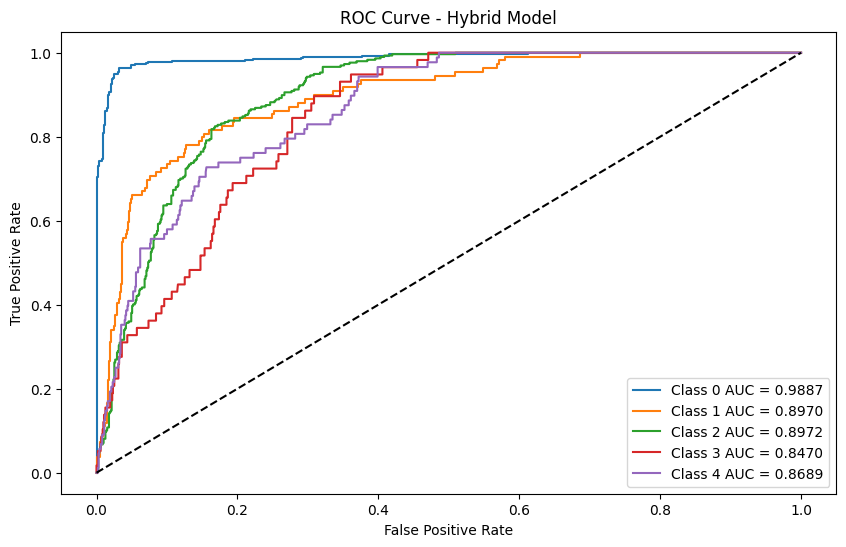

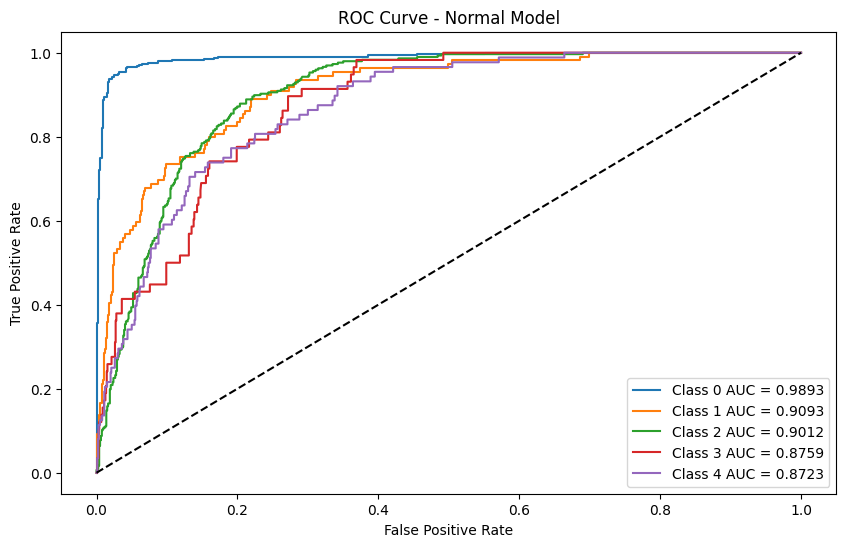

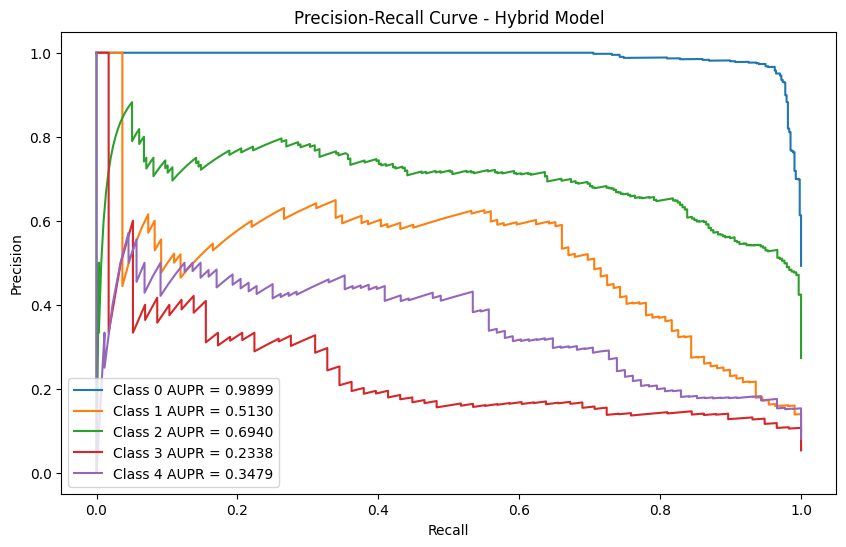

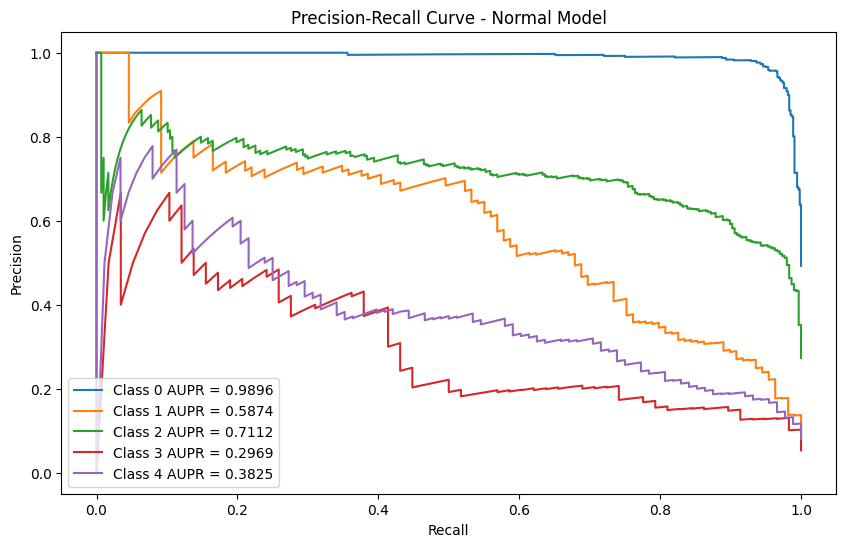

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 77.39%
Normal Model Accuracy: 77.48%
Hybrid Model F1 Score: 0.7251
Normal Model F1 Score: 0.7655
Hybrid Model AUC: 0.8904
Normal Model AUC: 0.9093
Hybrid Model AUPR: 0.5115
Normal Model AUPR: 0.5907


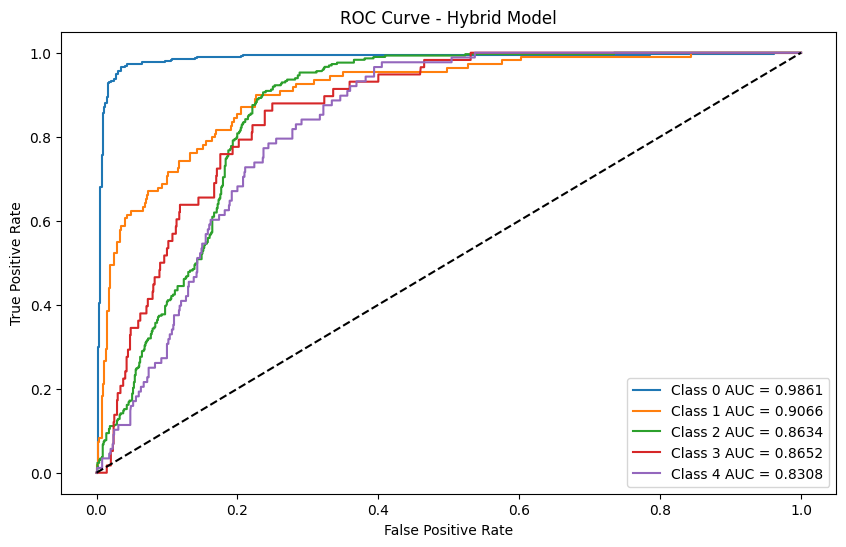

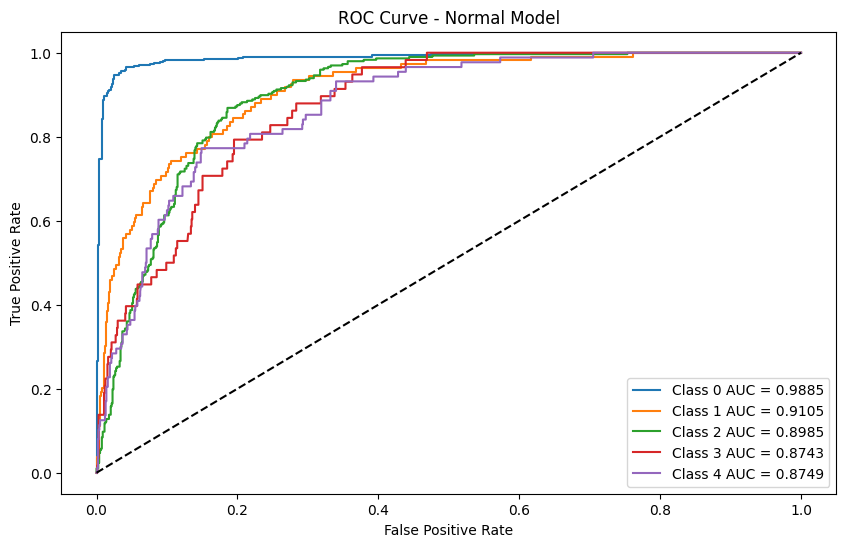

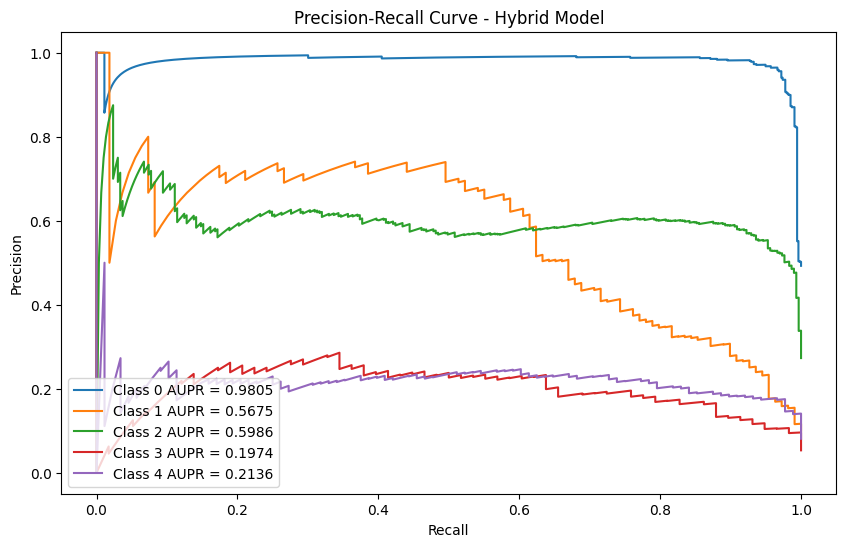

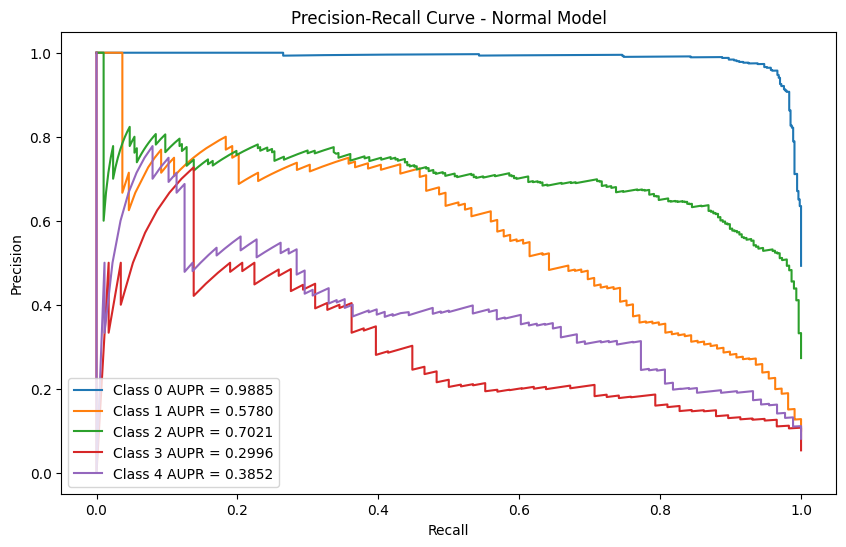

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 77.11%
Normal Model Accuracy: 78.31%
Hybrid Model F1 Score: 0.7484
Normal Model F1 Score: 0.7645
Hybrid Model AUC: 0.8994
Normal Model AUC: 0.9096
Hybrid Model AUPR: 0.5635
Normal Model AUPR: 0.5951


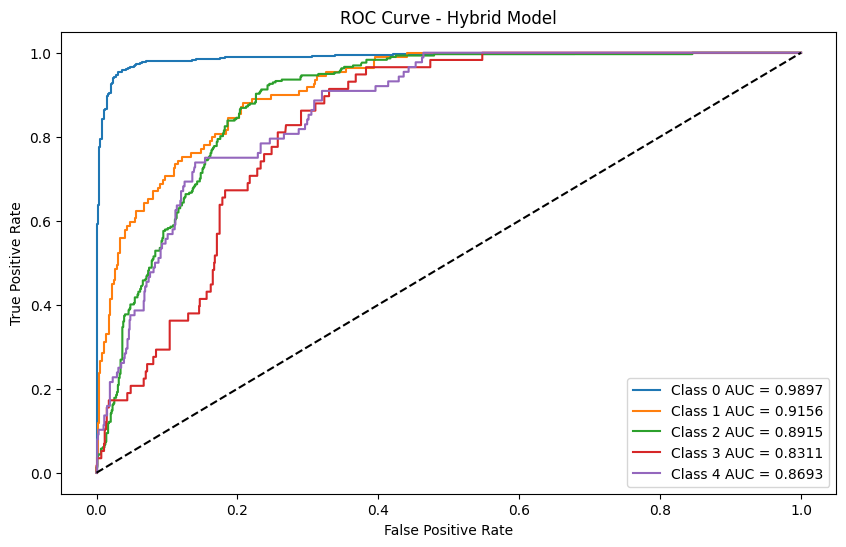

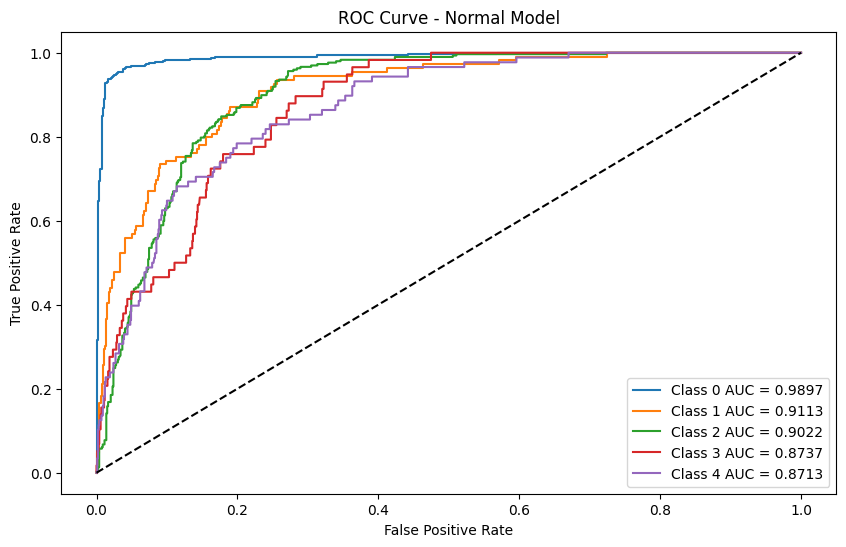

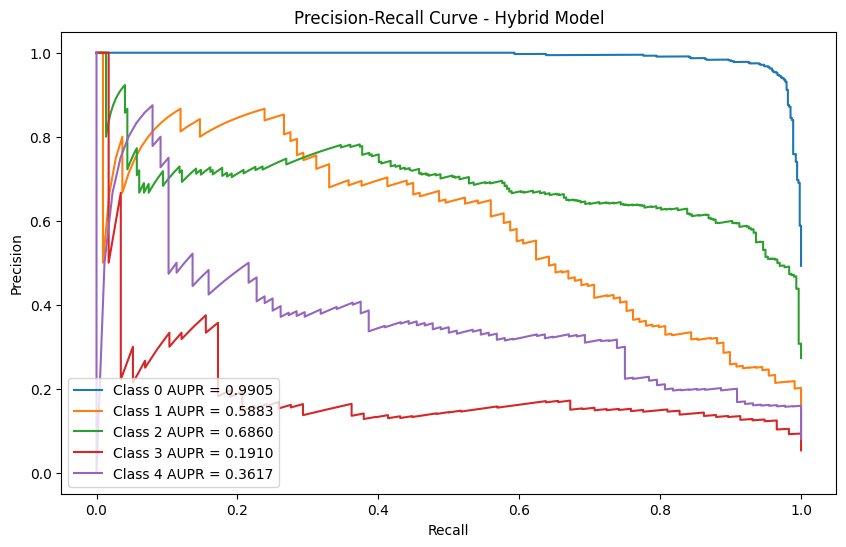

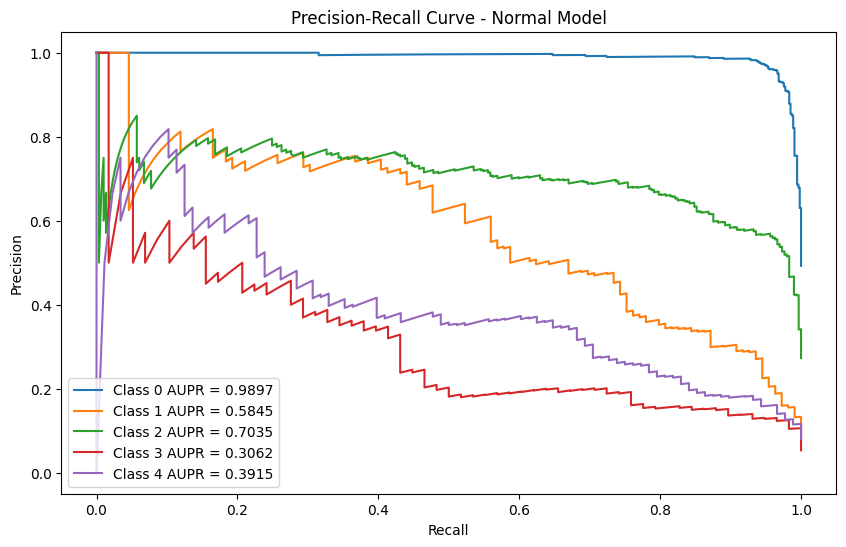

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 77.76%
Normal Model Accuracy: 76.93%
Hybrid Model F1 Score: 0.7619
Normal Model F1 Score: 0.7609
Hybrid Model AUC: 0.9026
Normal Model AUC: 0.9081
Hybrid Model AUPR: 0.5683
Normal Model AUPR: 0.5841


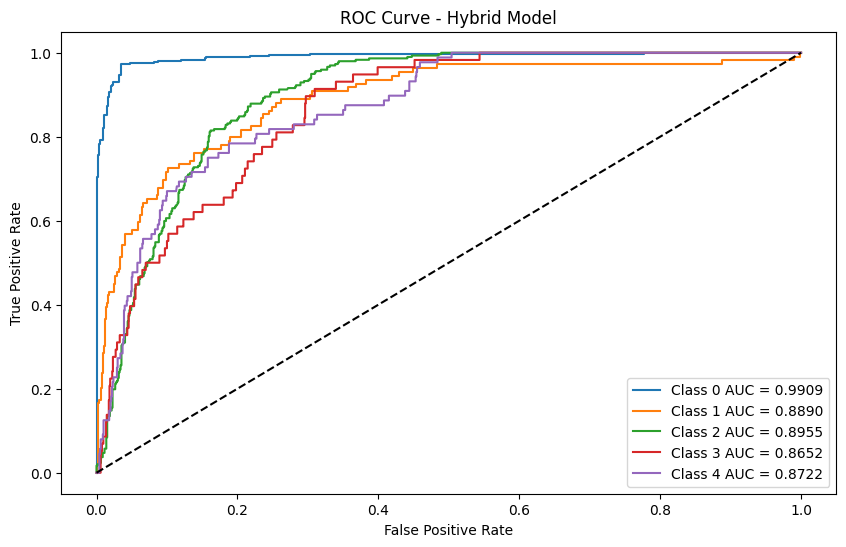

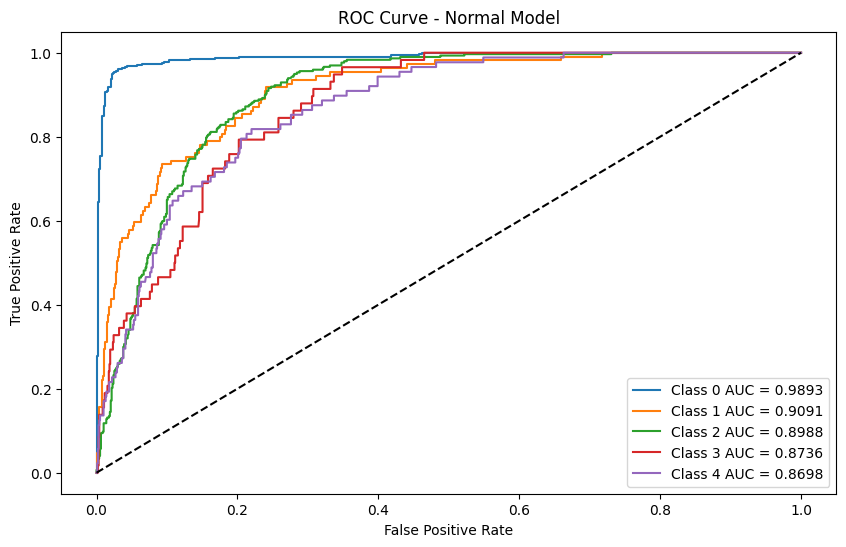

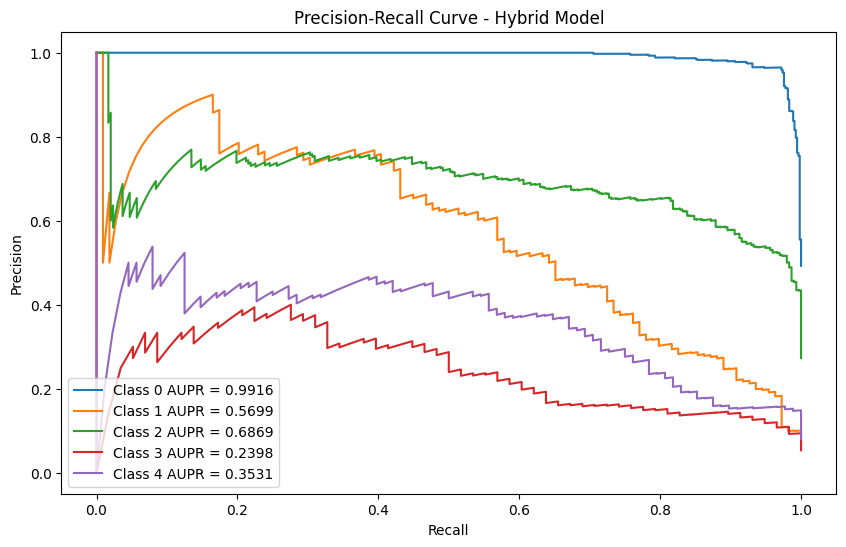

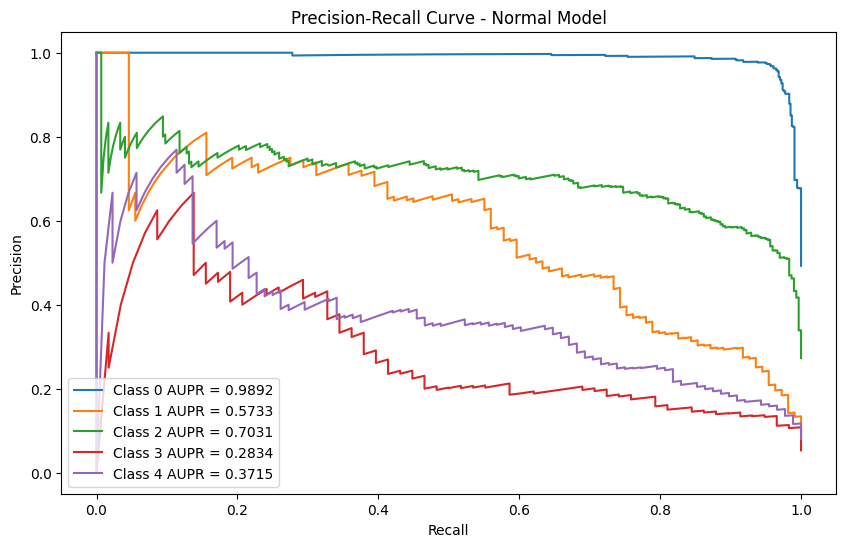

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 5

Hybrid Model Accuracy: 78.40%
Normal Model Accuracy: 78.22%
Hybrid Model F1 Score: 0.7553
Normal Model F1 Score: 0.7643
Hybrid Model AUC: 0.9001
Normal Model AUC: 0.9085
Hybrid Model AUPR: 0.5648
Normal Model AUPR: 0.5929


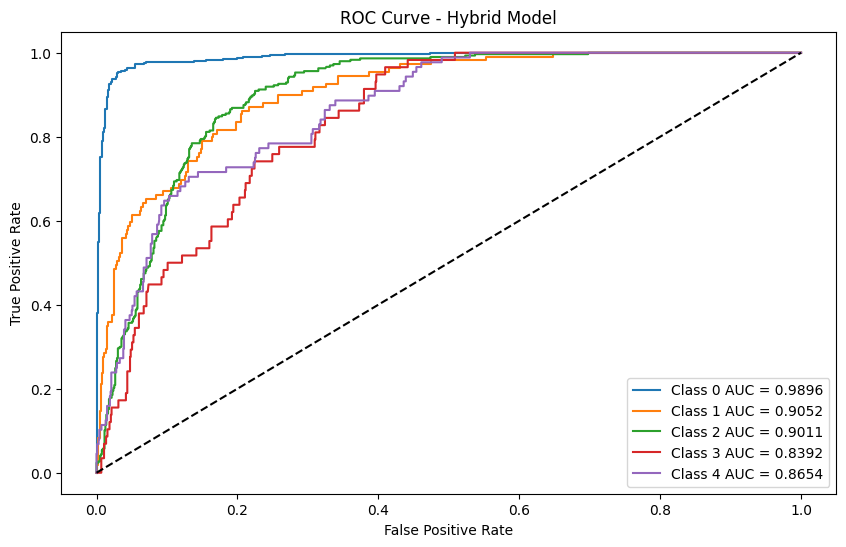

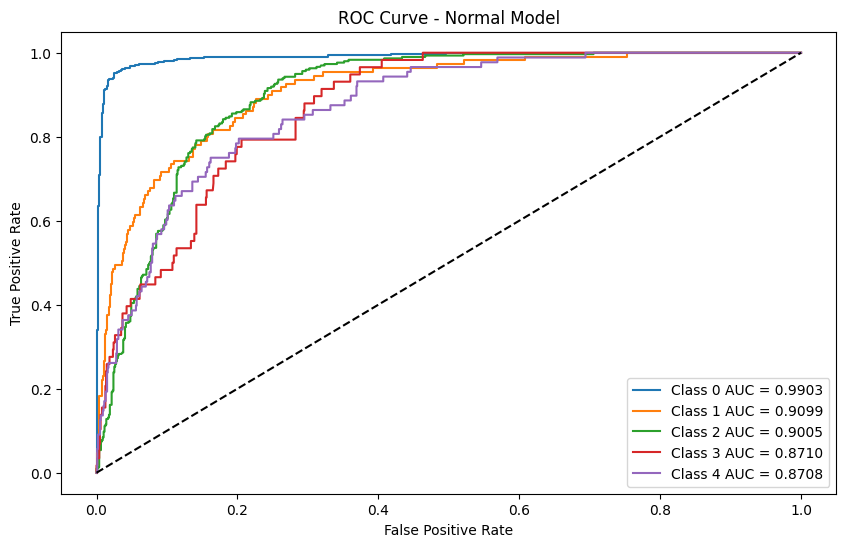

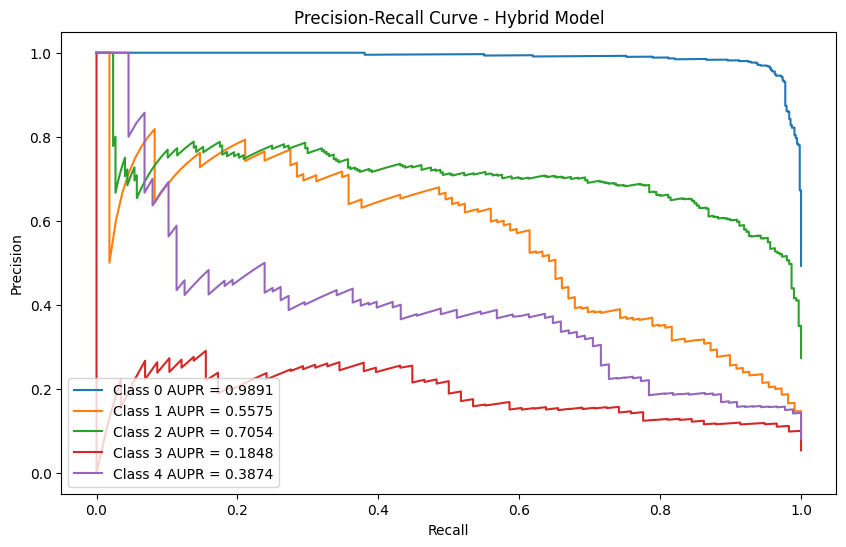

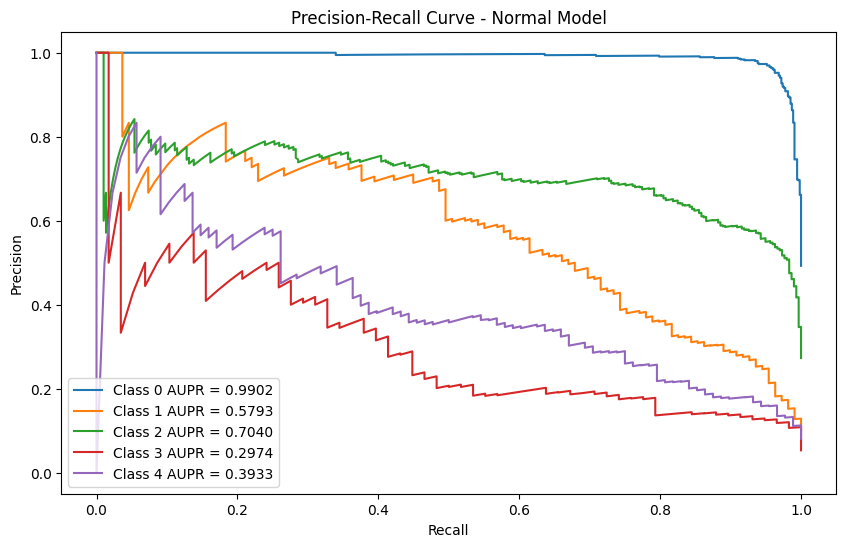

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_5923.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_5923.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

## Experimenting IDRID on MESSIDOR

In [ ]:
dataset = "Messidor"
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)

### Testing Model From Seed 1

Hybrid Model Accuracy: 56.45%
Normal Model Accuracy: 51.17%
Hybrid Model F1 Score: 0.4531
Normal Model F1 Score: 0.4874
Hybrid Model AUC: 0.6855
Normal Model AUC: 0.7258
Hybrid Model AUPR: 0.3387
Normal Model AUPR: 0.3252


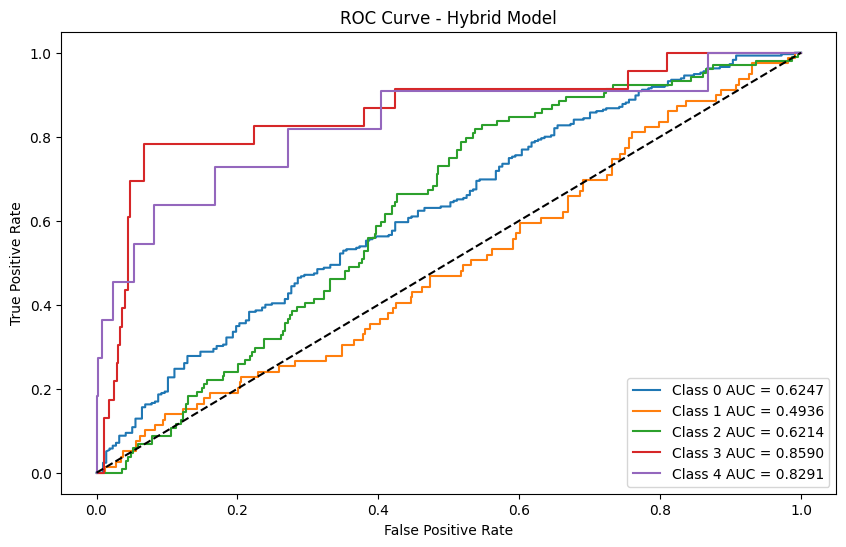

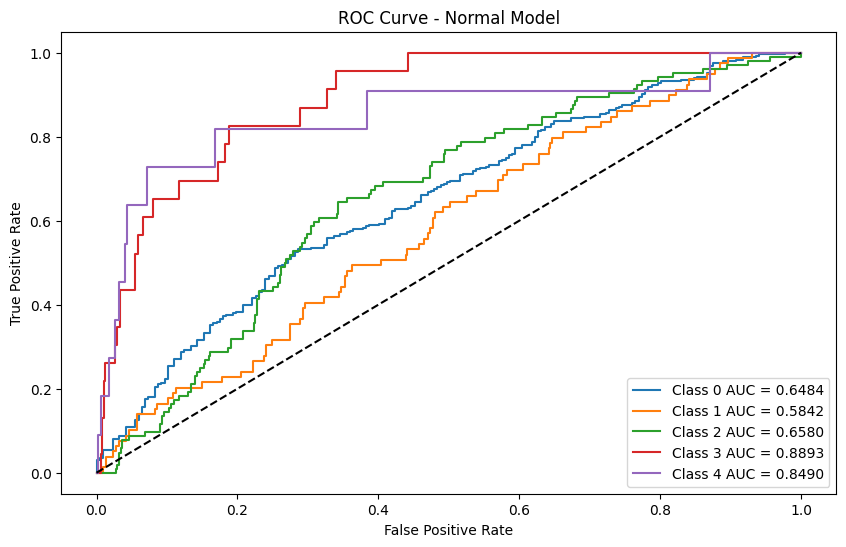

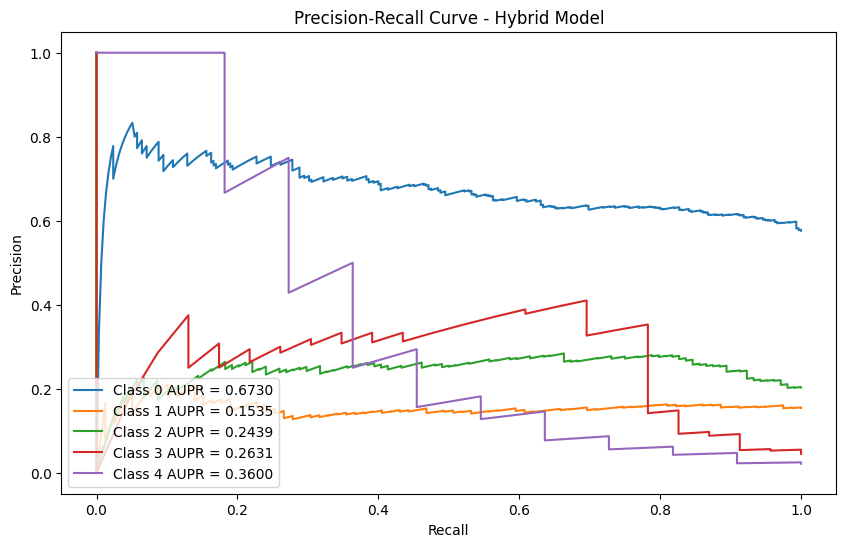

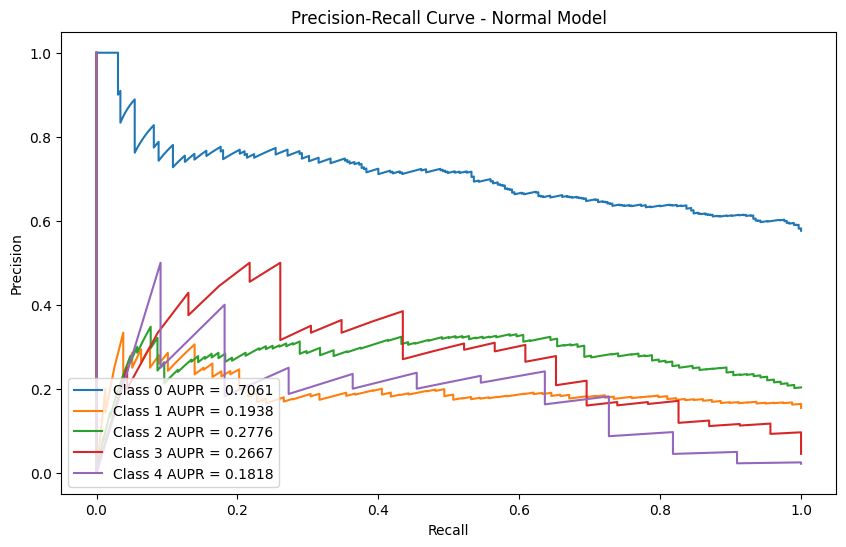

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 55.86%
Normal Model Accuracy: 49.02%
Hybrid Model F1 Score: 0.4716
Normal Model F1 Score: 0.4735
Hybrid Model AUC: 0.7169
Normal Model AUC: 0.7224
Hybrid Model AUPR: 0.3171
Normal Model AUPR: 0.3255


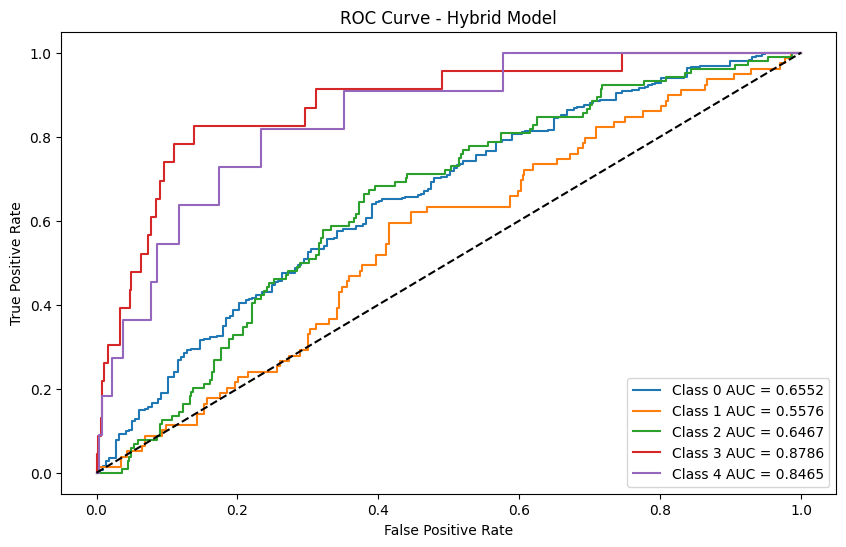

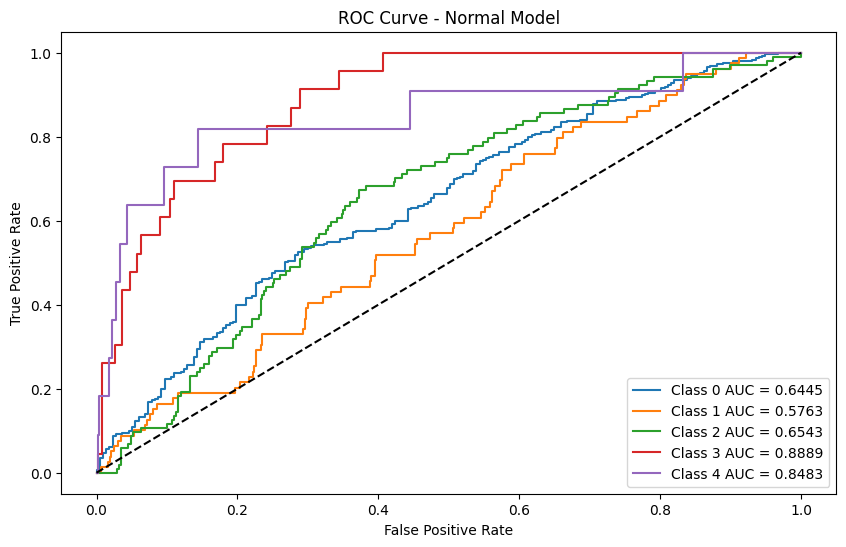

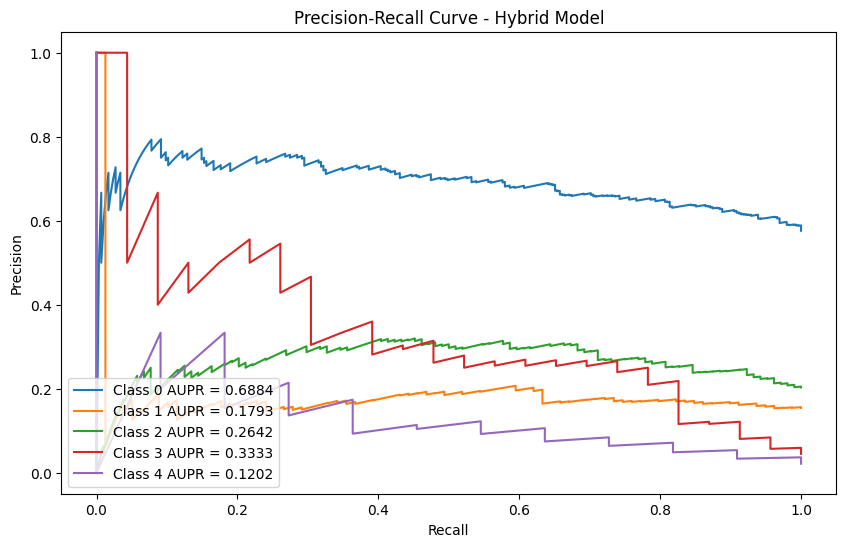

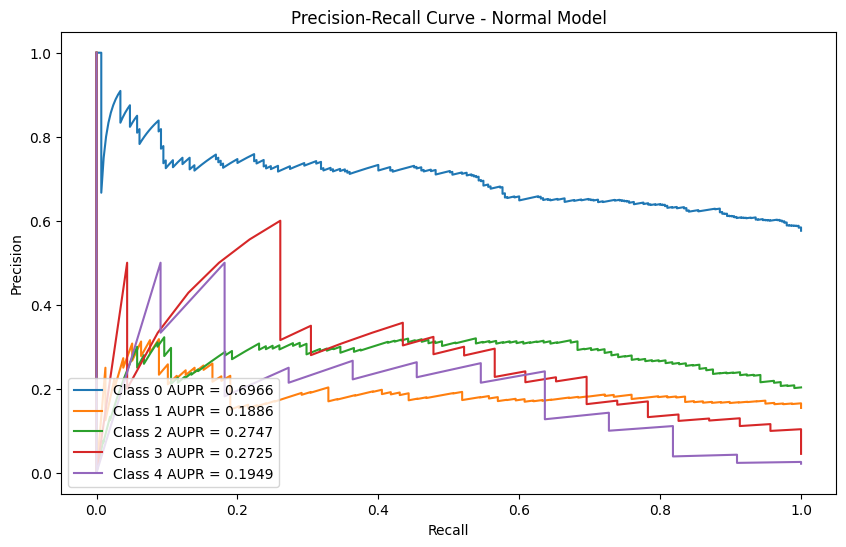

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 55.86%
Normal Model Accuracy: 55.27%
Hybrid Model F1 Score: 0.4535
Normal Model F1 Score: 0.5047
Hybrid Model AUC: 0.6951
Normal Model AUC: 0.7264
Hybrid Model AUPR: 0.3327
Normal Model AUPR: 0.3499


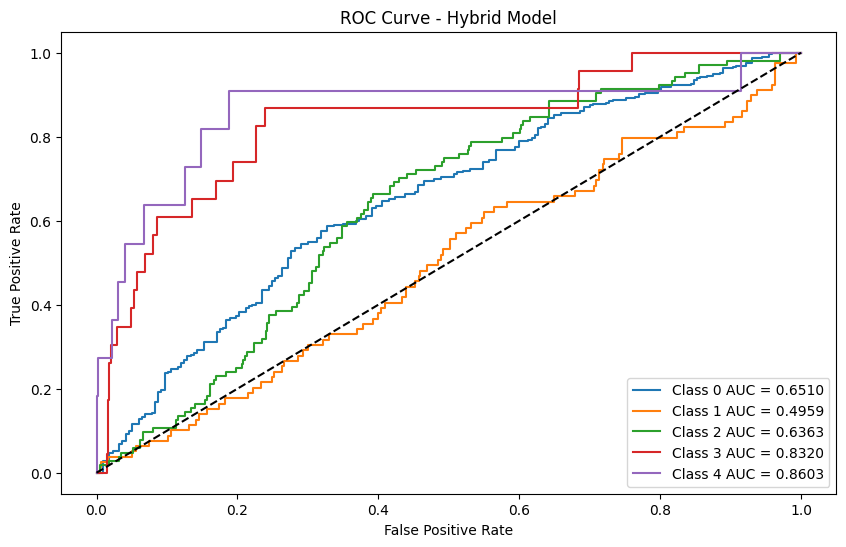

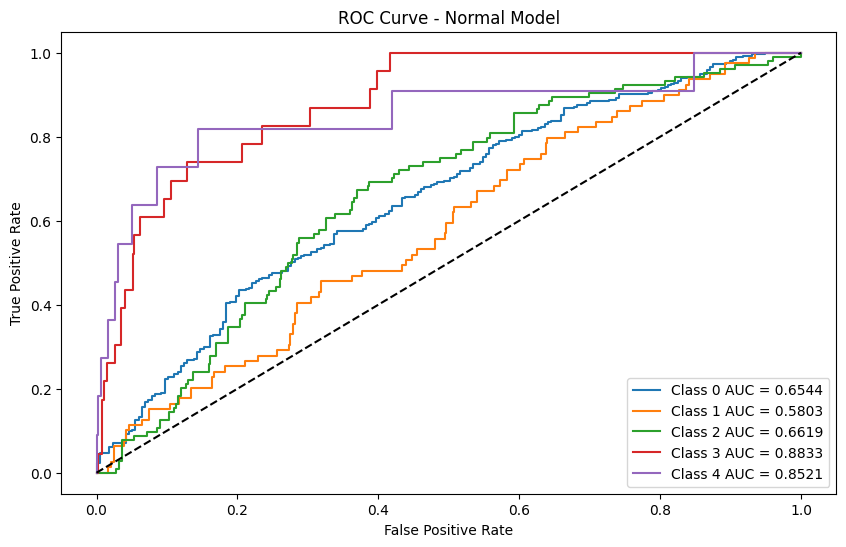

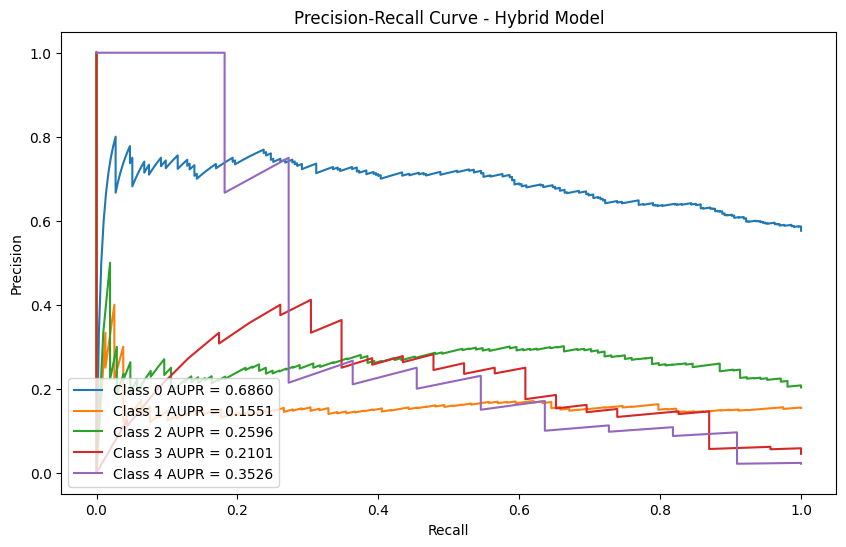

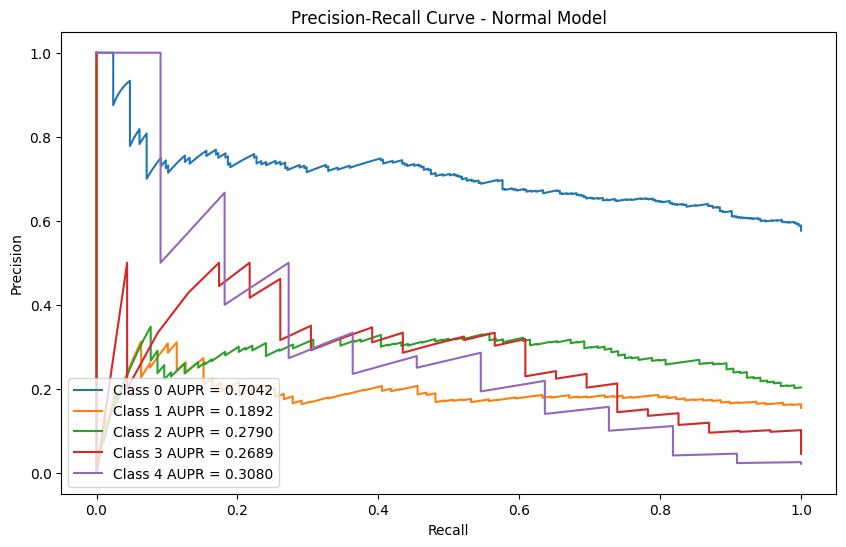

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 54.49%
Normal Model Accuracy: 54.30%
Hybrid Model F1 Score: 0.4823
Normal Model F1 Score: 0.4945
Hybrid Model AUC: 0.6807
Normal Model AUC: 0.7248
Hybrid Model AUPR: 0.3191
Normal Model AUPR: 0.3529


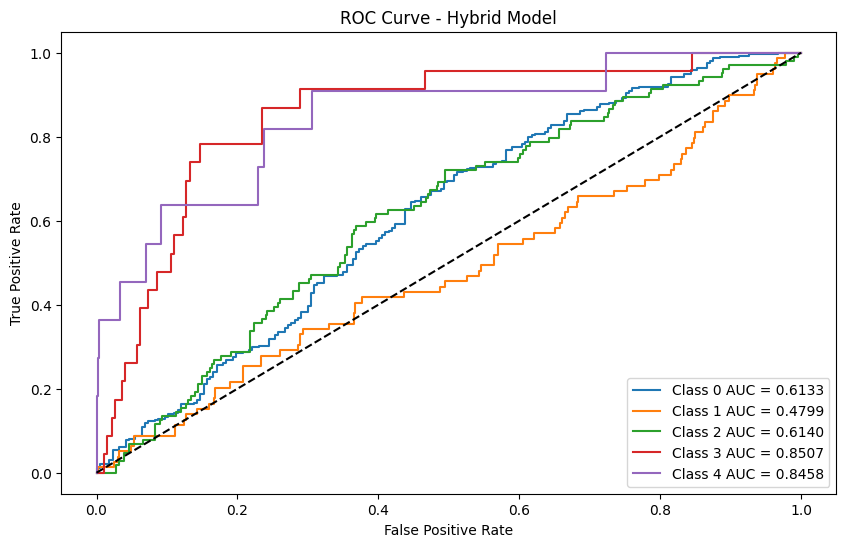

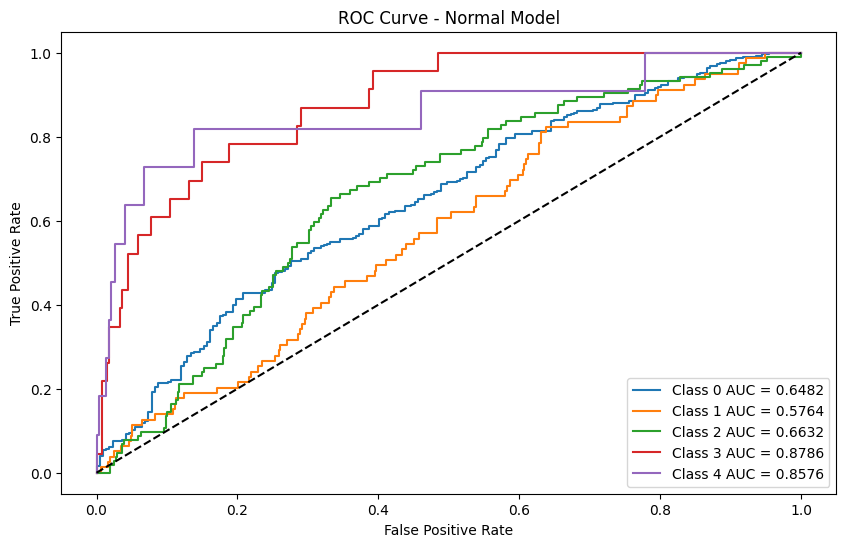

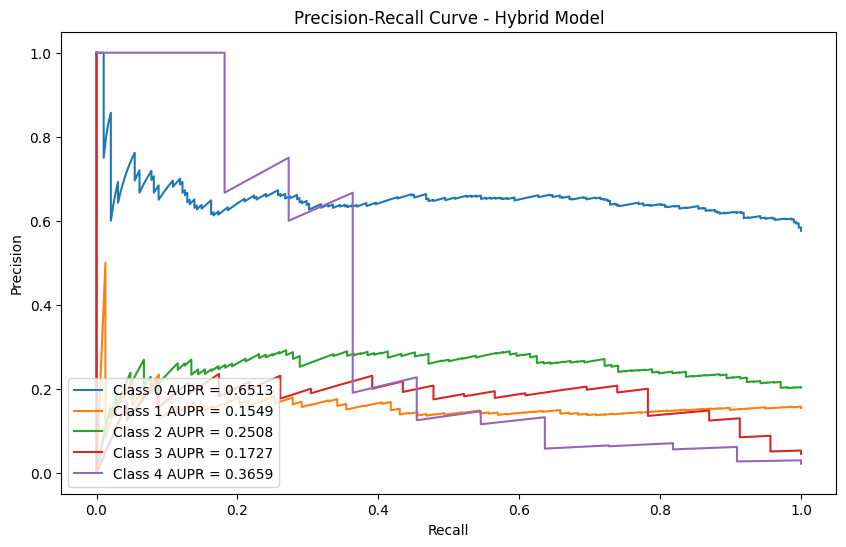

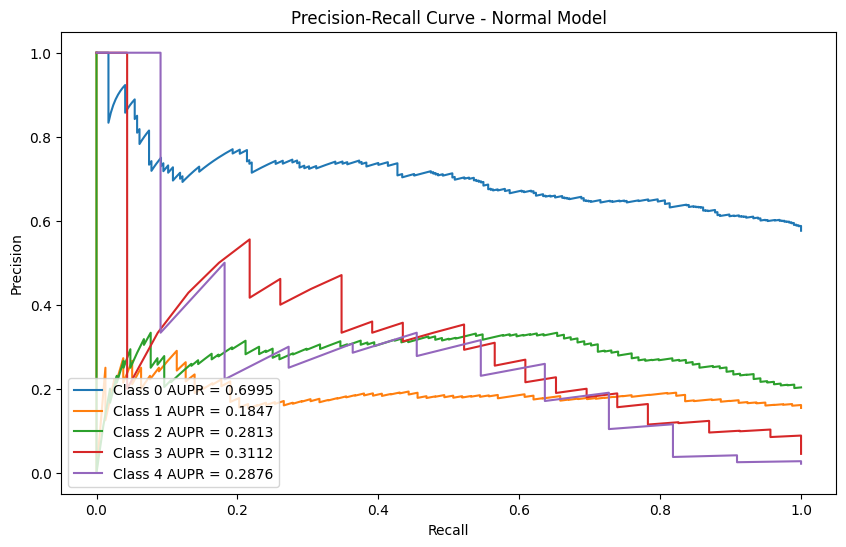

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 5

Hybrid Model Accuracy: 53.52%
Normal Model Accuracy: 53.91%
Hybrid Model F1 Score: 0.4699
Normal Model F1 Score: 0.4972
Hybrid Model AUC: 0.6969
Normal Model AUC: 0.7260
Hybrid Model AUPR: 0.3271
Normal Model AUPR: 0.3404


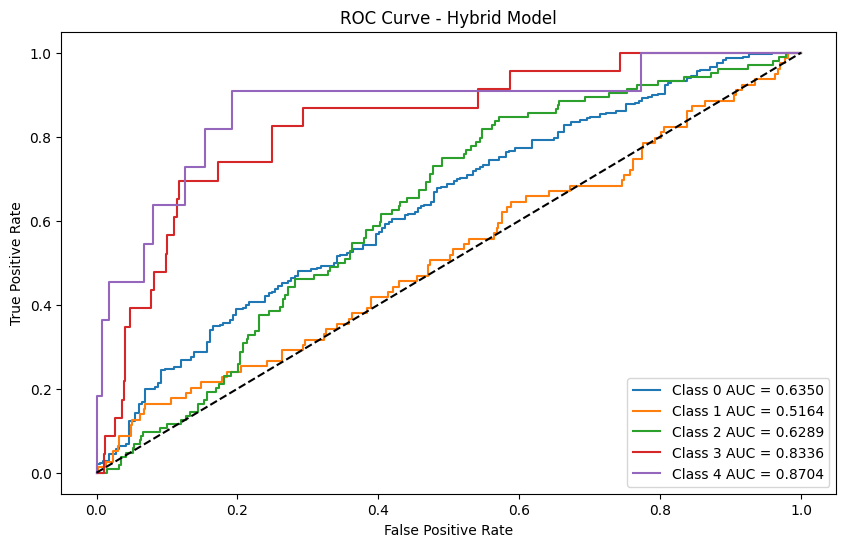

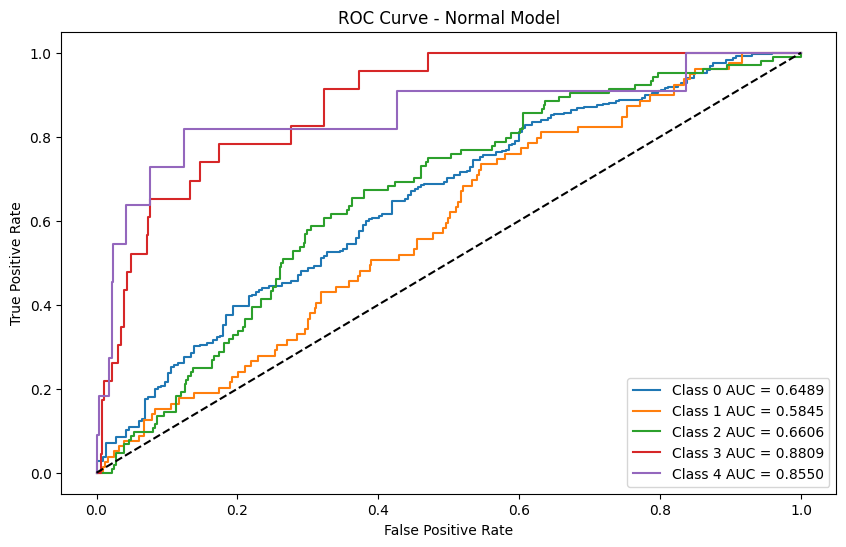

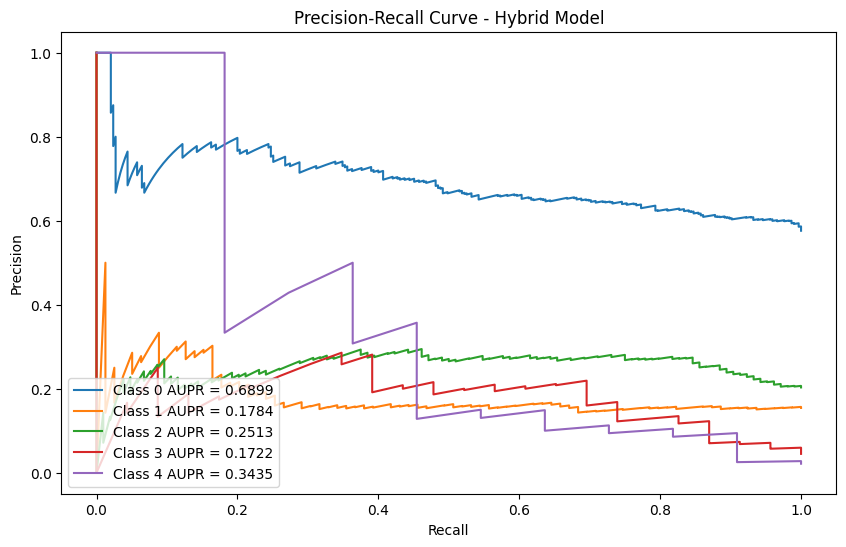

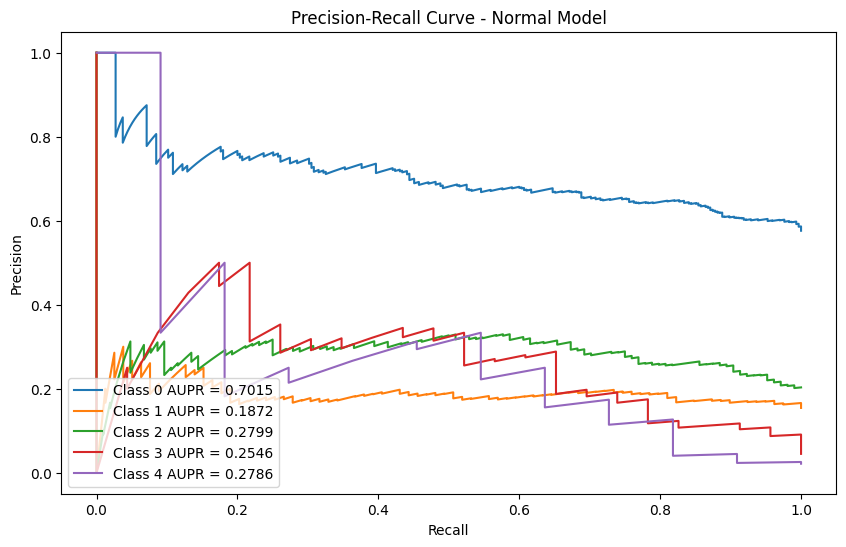

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/normal_model_5923.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_models/quantum_hybrid_model_5923.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)